<a href="https://colab.research.google.com/github/arpan1975/signals-4-swing-trading/blob/main/Swing%20Trading%20Strategy%20using%20EMA_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
# Swing Testing Strategy

---

> Strategy Overview:
> This strategy aims to capture teh short and mid-term trends of the stock.

> Strategy Principles:
> Core princplies are as follows:

> Calculate two moving averages, fast-EMA (20d) and slow-EMA (50d)
> Make an entry when closing price crosses above the fast-EMA
> Make an exit when closing price crosse below the fast-EMA and slow-EMA is above fast-EMA, holding duration is erual to or greater than 25 days
> Make an exit when price goes below stop-loss (2% of buy price)

```



In [1]:
""" Include all required libraries
"""
import yfinance as yf
import pandas as pd
import numpy as np
import math
from termcolor import colored as cl
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
""" Function to add calculate the return for each stock for the given period
"""
def calculate_return(df, ticker, start, end, investment, stop_loss_pct, duration):

    implement_strategy(df, ticker, start, end, investment, stop_loss_pct, duration)
    generate_plot(df, ticker)

In [3]:
""" Function to log all buy and sell transactions
"""
def implement_strategy(df, ticker, start, end, investment, stop_loss_pct, duration):

## pending: add the logic of training stop loss
    in_position = False
    equity = investment
    stop_loss = 0
    target_book = 0
    buy_price = 0
    start_d = 0

    print(cl(f'\nOrder book for {ticker} between {start} and {end}', attrs = ['bold']))
    print(f'------------------------------------------------')

    for i in range(3, len(df)):

        if df['Close'][i] > df['EMA_M'][i] and df['CL_EMA(M)'][i] < 1 and in_position == False:
            buy_price = df.Close[i]
            no_of_shares = math.floor(equity/df.Close[i])
            equity -= (no_of_shares * df.Close[i])
            in_position = True
            df['Buy'][i] = 1
            stop_loss = df.Close[i] * (1 - stop_loss_pct)
            target_book = df.Close[i] * (1 + 2 * stop_loss_pct)
            start_d = i
            print(cl('BUY: ', color = 'green', attrs = ['bold']), f'{no_of_shares} Shares are bought at ₹{df.Close[i]} on {df.index[i]}')
        elif df['Close'][i] < df['EMA_M'][i] and df['Close'][i] < df['EMA_L'][i] and df['EMA_L'][i] > df['EMA_M'][i] and df['CL_EMA(M)'][i] > 1 \
        and (i - start_d) >= duration and in_position == True:
            print(i, start_d)
            equity += (no_of_shares * df.Close[i])
            in_position = False
            df['Sell'][i] = 1
            stop_loss = 0
            target_book = 0
            start_d = 0
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{no_of_shares} Shares are sold at ₹{df.Close[i]} on {df.index[i]}')
        elif df['Low'][i] <= stop_loss and in_position == True:
            equity += (no_of_shares * df.Close[i])
            in_position = False
            df['Sell'][i] = 1
            stop_loss = 0
            target_book = 0
            start_d = 0
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{no_of_shares} Shares are sold at ₹{df.Close[i]} on {df.index[i]}')
        #elif df['Close'][i] * (1 - stop_loss_pct) > stop_loss and df['Close'][i] > buy_price and in_position == True:
        #    stop_loss = df['Close'][i] * (1 - stop_loss_pct)

    if in_position == True:
        equity += (no_of_shares * df.Close[i])
        print(cl(f'\nClosing position at {df.Close[i]} on {df.index[i]}', attrs = ['bold']))
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)

    print('')
    print(cl(f'EARNING: ₹{earning} ; ROI: {roi}%', attrs = ['bold']))

    equity_1 = investment
    equity_1 = (math.floor(equity_1/df.Open[0]) * df.Close[i])
    earning_1 = round(equity_1 - investment, 2)
    roi_1 = round(earning_1 / investment * 100, 2)

    return_data.append([ticker, earning, roi, earning_1, roi_1])

    print(cl(f'Return with Buy-Hold strategy: EARNING: ₹{earning_1} ; ROI: {roi_1}%\n', attrs = ['bold']))
    #print(df.index[0], df.index[len(df) - 1])


In [4]:
""" Function to extract ticker list from Wikipedia source
"""
def get_ticker_list(url):

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    '''   @ Use this for Nifty50 stocks     '''
    table = soup.find('table', attrs={'class': 'wikitable sortable'})
    '''   @ Use this for Nifty500 stocks    '''
    #table = soup.find('table', attrs={'class': 'wikitable sortable mw-collapsible'})
    table_rows = table.find_all('tr')
    data = []
    for row in table.find_all('tr'):
        row_data = []
        for cell in row.find_all('th'):
            row_data.append(cell.text.replace('\n', ''))
        for cell in row.find_all('td'):
            row_data.append(cell.text.replace('\n', ''))
        data.append(row_data)
    header = data[0]
    tickers = pd.DataFrame(data[1:], columns=header)['Symbol'].tolist()
    for idx, item in enumerate(tickers):
        item = tickers[idx] + '.NS'
        tickers[idx] = item
    return tickers

In [5]:
""" Function to extract historical price using Yahoo Finance
"""
def extract_hist_price(ticker, period):

    df = yf.download(ticker, period=period)
    return df

In [6]:
""" Function to add EMA Indicators to the dataframe
"""
def add_ema_indicators(df, s, m, l):

    EMA_S_INTERVAL = s
    EMA_M_INTERVAL = m
    EMA_L_INTERVAL = l
    df['EMA_S'] = df['Close'].ewm(span=s, adjust=False).mean()
    df['EMA_M'] = df['Close'].ewm(span=m, adjust=False).mean()
    df['EMA_L'] = df['Close'].ewm(span=l, adjust=False).mean()
    df['CL_EMA(S)'] = df['Close']/df['EMA_S']
    df['CL_EMA(S)'] = df['CL_EMA(S)'].shift(1)
    df['CL_EMA(M)'] = df['Close']/df['EMA_M']
    df['CL_EMA(M)'] = df['CL_EMA(M)'].shift(1)
    df['EMA(SM)']  = df['EMA_S']/df['EMA_M']
    df['EMA(SM)'] = df['EMA(SM)'].shift(1)
    df['Buy'] = 0
    df['Sell'] = 0
    return df

In [7]:
def generate_plot(df, ticker):

    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Close'], label='Close', color='blue', lw='0.5')
    plt.plot(df.index, df['EMA_M'], label='EMA_M', color='green', lw='0.75')
    plt.plot(df.index, df['EMA_L'], label='EMA_L', color='orange', lw='0.75')

    df['Buy_Signal'] = np.where(df['Buy'] == 1, True, False)
    df['Sell_Signal'] = np.where(df['Sell'] == 1, True, False)
    # Adding buy signals
    buy_signals = df.index[df['Buy_Signal']]
    plt.scatter(buy_signals, df['Close'][df['Buy_Signal']], marker='^', color='green', label='Buy Signal', s=100)

    # Adding sell signals
    sell_signals = df.index[df['Sell_Signal']]
    plt.scatter(sell_signals, df['Close'][df['Sell_Signal']], marker='v', color='red', label='Sell Signal', s=100)

    # Adding legend and labels
    plt.title(f'{ticker} : Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%***********************]  1 of 1 completed



Order book for ADANIENT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  480 Shares are bought at ₹208.0 on 2020-01-09 00:00:00
SELL:  480 Shares are sold at ₹199.6999969482422 on 2020-03-09 00:00:00
BUY:  685 Shares are bought at ₹140.0500030517578 on 2020-05-11 00:00:00
SELL:  685 Shares are sold at ₹139.89999389648438 on 2020-05-12 00:00:00
BUY:  686 Shares are bought at ₹139.6999969482422 on 2020-05-19 00:00:00
SELL:  686 Shares are sold at ₹138.10000610351562 on 2020-05-22 00:00:00
BUY:  679 Shares are bought at ₹139.5 on 2020-05-26 00:00:00
796 96
SELL:  679 Shares are sold at ₹1738.199951171875 on 2023-03-14 00:00:00
BUY:  641 Shares are bought at ₹1839.0 on 2023-03-15 00:00:00
SELL:  641 Shares are sold at ₹1843.800048828125 on 2023-03-16 00:00:00
BUY:  658 Shares are bought at ₹1797.25 on 2023-04-10 00:00:00

Closing position at 2848.949951171875 on 2023-12-29 00:00:00

EARNING: ₹1775428.31 ; ROI: 1775.43%
Return with Buy-Hold strate

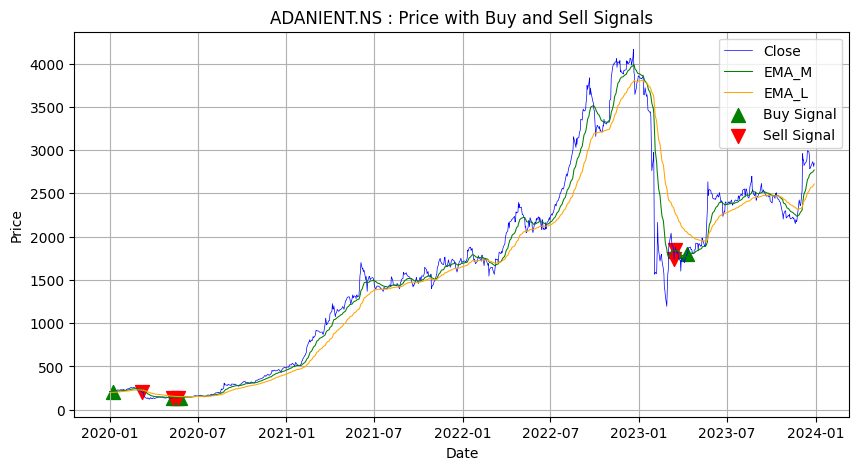

[*********************100%***********************]  1 of 1 completed



Order book for ADANIPORTS.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  260 Shares are bought at ₹383.6000061035156 on 2020-01-22 00:00:00
SELL:  260 Shares are sold at ₹372.95001220703125 on 2020-01-28 00:00:00
BUY:  253 Shares are bought at ₹383.3500061035156 on 2020-01-29 00:00:00
SELL:  253 Shares are sold at ₹369.3999938964844 on 2020-01-31 00:00:00
BUY:  348 Shares are bought at ₹268.8999938964844 on 2020-04-15 00:00:00
SELL:  348 Shares are sold at ₹267.6000061035156 on 2020-04-16 00:00:00
BUY:  342 Shares are bought at ₹271.8999938964844 on 2020-04-22 00:00:00
SELL:  342 Shares are sold at ₹266.3500061035156 on 2020-05-04 00:00:00
BUY:  323 Shares are bought at ₹282.3999938964844 on 2020-05-07 00:00:00
SELL:  323 Shares are sold at ₹309.3500061035156 on 2020-05-13 00:00:00
BUY:  305 Shares are bought at ₹327.1000061035156 on 2020-08-05 00:00:00
SELL:  305 Shares are sold at ₹324.6000061035156 on 2020-09-23 00:00:00
BUY:  291 Shares

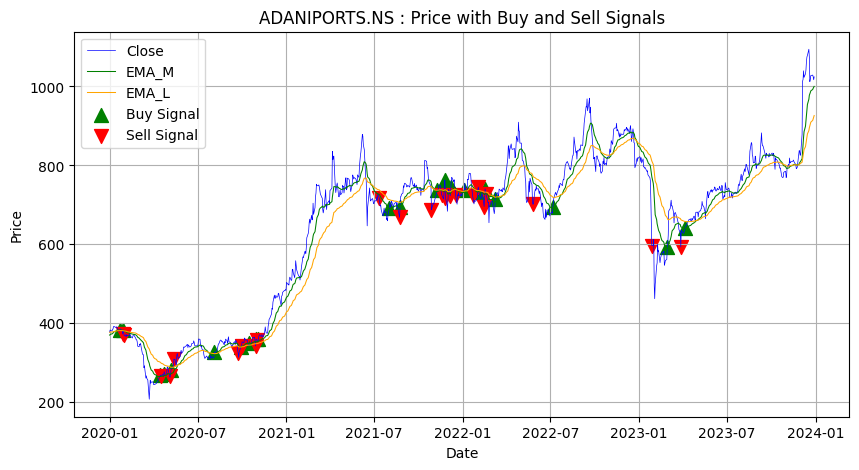

[*********************100%***********************]  1 of 1 completed



Order book for APOLLOHOSP.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  73 Shares are bought at ₹1360.550048828125 on 2020-04-15 00:00:00
SELL:  73 Shares are sold at ₹1351.1500244140625 on 2020-04-21 00:00:00
BUY:  73 Shares are bought at ₹1355.300048828125 on 2020-05-15 00:00:00
SELL:  73 Shares are sold at ₹1266.050048828125 on 2020-05-18 00:00:00
BUY:  70 Shares are bought at ₹1321.75 on 2020-05-26 00:00:00
457 96
SELL:  70 Shares are sold at ₹4289.89990234375 on 2021-11-02 00:00:00
BUY:  67 Shares are bought at ₹4438.60009765625 on 2021-11-03 00:00:00
SELL:  67 Shares are sold at ₹4486.0 on 2022-01-25 00:00:00
BUY:  64 Shares are bought at ₹4687.89990234375 on 2022-02-04 00:00:00
SELL:  64 Shares are sold at ₹4475.14990234375 on 2022-02-07 00:00:00
BUY:  62 Shares are bought at ₹4663.39990234375 on 2022-02-15 00:00:00
SELL:  62 Shares are sold at ₹4584.7998046875 on 2022-02-16 00:00:00
BUY:  62 Shares are bought at ₹4576.0498046875 on

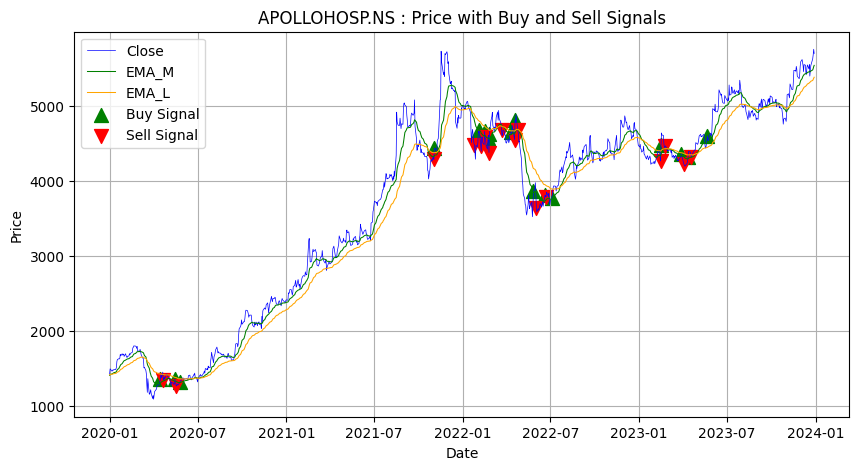

[*********************100%***********************]  1 of 1 completed



Order book for ASIANPAINT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  56 Shares are bought at ₹1772.550048828125 on 2020-01-09 00:00:00
SELL:  56 Shares are sold at ₹1797.699951171875 on 2020-03-13 00:00:00
BUY:  60 Shares are bought at ₹1680.8499755859375 on 2020-04-13 00:00:00
SELL:  60 Shares are sold at ₹1619.1500244140625 on 2020-05-05 00:00:00
BUY:  60 Shares are bought at ₹1617.9000244140625 on 2020-05-22 00:00:00
SELL:  60 Shares are sold at ₹1637.3499755859375 on 2020-06-12 00:00:00
BUY:  59 Shares are bought at ₹1652.1500244140625 on 2020-06-22 00:00:00
299 115
SELL:  59 Shares are sold at ₹2401.35009765625 on 2021-03-12 00:00:00
BUY:  57 Shares are bought at ₹2468.60009765625 on 2021-03-16 00:00:00
SELL:  57 Shares are sold at ₹2422.949951171875 on 2021-03-17 00:00:00
BUY:  57 Shares are bought at ₹2425.699951171875 on 2021-03-22 00:00:00
460 305
SELL:  57 Shares are sold at ₹3138.0 on 2021-11-08 00:00:00
BUY:  57 Shares are b

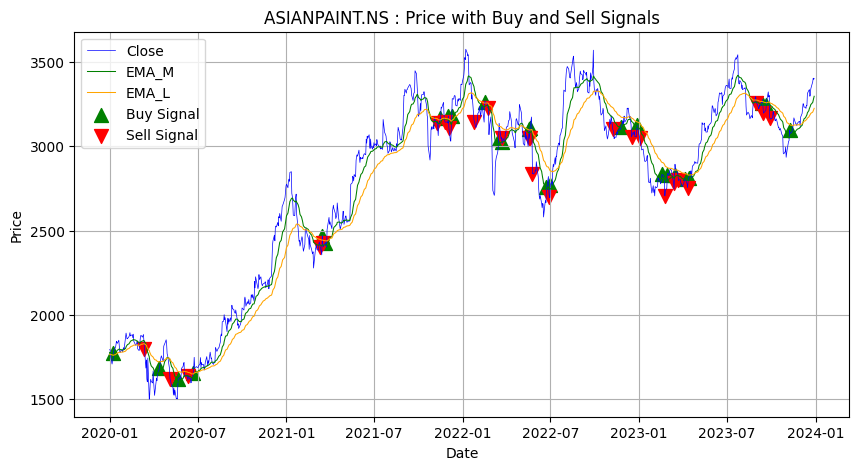

[*********************100%***********************]  1 of 1 completed



Order book for AXISBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  134 Shares are bought at ₹742.8499755859375 on 2020-01-09 00:00:00
SELL:  134 Shares are sold at ₹727.2000122070312 on 2020-01-20 00:00:00
BUY:  132 Shares are bought at ₹737.4000244140625 on 2020-01-24 00:00:00
SELL:  132 Shares are sold at ₹708.9500122070312 on 2020-02-03 00:00:00
BUY:  127 Shares are bought at ₹736.9500122070312 on 2020-02-06 00:00:00
SELL:  127 Shares are sold at ₹728.75 on 2020-02-25 00:00:00
BUY:  126 Shares are bought at ₹735.8499755859375 on 2020-02-27 00:00:00
SELL:  126 Shares are sold at ₹697.2999877929688 on 2020-02-28 00:00:00
BUY:  184 Shares are bought at ₹478.79998779296875 on 2020-04-17 00:00:00
SELL:  184 Shares are sold at ₹455.95001220703125 on 2020-04-20 00:00:00
BUY:  184 Shares are bought at ₹455.45001220703125 on 2020-04-28 00:00:00
SELL:  184 Shares are sold at ₹439.1000061035156 on 2020-04-29 00:00:00
BUY:  195 Shares are bought

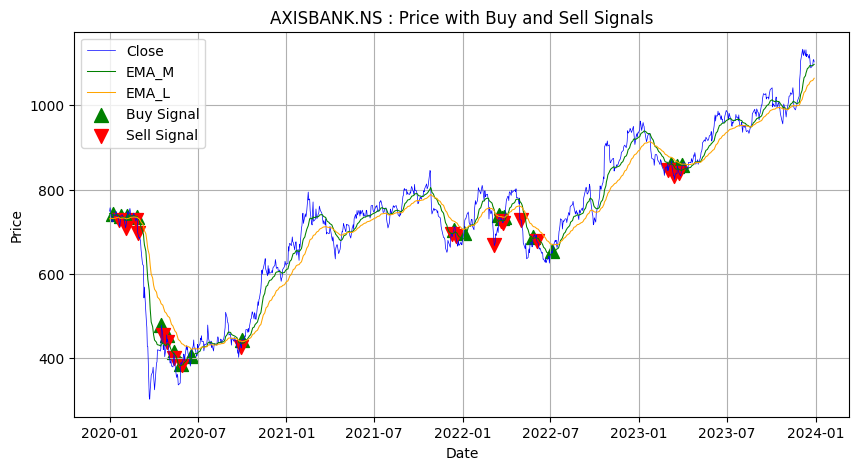

[*********************100%***********************]  1 of 1 completed



Order book for BAJAJ-AUTO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  31 Shares are bought at ₹3145.5 on 2020-01-30 00:00:00
SELL:  31 Shares are sold at ₹3075.60009765625 on 2020-02-17 00:00:00
BUY:  42 Shares are bought at ₹2280.050048828125 on 2020-04-07 00:00:00
SELL:  42 Shares are sold at ₹2241.699951171875 on 2020-04-08 00:00:00
BUY:  39 Shares are bought at ₹2419.050048828125 on 2020-05-08 00:00:00
313 85
SELL:  39 Shares are sold at ₹3598.5 on 2021-04-05 00:00:00
BUY:  38 Shares are bought at ₹3681.39990234375 on 2021-04-22 00:00:00
420 324
SELL:  38 Shares are sold at ₹3725.35009765625 on 2021-09-08 00:00:00
BUY:  38 Shares are bought at ₹3751.050048828125 on 2021-09-14 00:00:00
SELL:  38 Shares are sold at ₹3707.25 on 2021-10-29 00:00:00
BUY:  37 Shares are bought at ₹3794.449951171875 on 2021-11-09 00:00:00
SELL:  37 Shares are sold at ₹3635.050048828125 on 2021-11-12 00:00:00
BUY:  41 Shares are bought at ₹3262.5 on 2021-12-

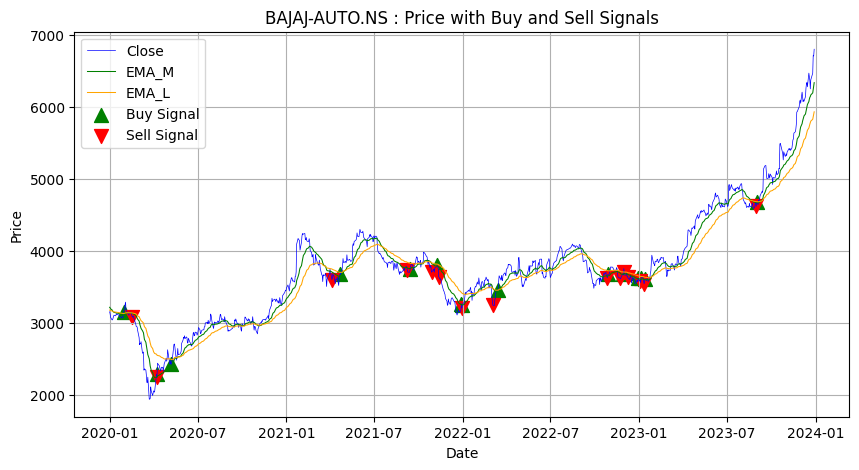

[*********************100%***********************]  1 of 1 completed



Order book for BAJFINANCE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  24 Shares are bought at ₹4124.2001953125 on 2020-01-09 00:00:00
SELL:  24 Shares are sold at ₹4225.85009765625 on 2020-03-06 00:00:00
BUY:  47 Shares are bought at ₹2160.85009765625 on 2020-06-01 00:00:00
204 100
SELL:  47 Shares are sold at ₹3293.89990234375 on 2020-10-26 00:00:00
BUY:  45 Shares are bought at ₹3453.25 on 2020-10-27 00:00:00
SELL:  45 Shares are sold at ₹3370.800048828125 on 2020-10-28 00:00:00
BUY:  44 Shares are bought at ₹3419.800048828125 on 2020-11-02 00:00:00
484 209
SELL:  44 Shares are sold at ₹7218.75 on 2021-12-13 00:00:00
BUY:  45 Shares are bought at ₹6977.2998046875 on 2021-12-31 00:00:00
SELL:  45 Shares are sold at ₹6931.75 on 2022-01-24 00:00:00
BUY:  43 Shares are bought at ₹7247.4501953125 on 2022-02-02 00:00:00
SELL:  43 Shares are sold at ₹7110.64990234375 on 2022-02-03 00:00:00
BUY:  43 Shares are bought at ₹7142.0498046875 on 202

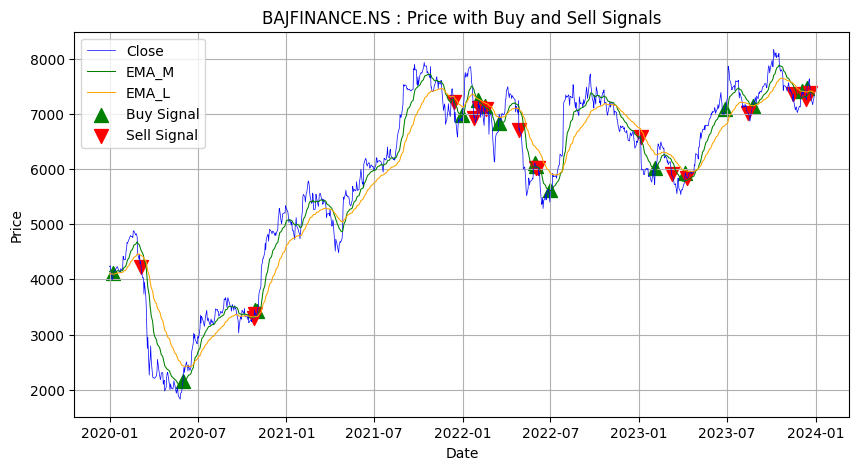

[*********************100%***********************]  1 of 1 completed



Order book for BAJAJFINSV.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  106 Shares are bought at ₹939.5250244140625 on 2020-01-09 00:00:00
SELL:  106 Shares are sold at ₹908.614990234375 on 2020-02-03 00:00:00
BUY:  101 Shares are bought at ₹953.489990234375 on 2020-02-04 00:00:00
SELL:  101 Shares are sold at ₹940.7999877929688 on 2020-02-27 00:00:00
BUY:  186 Shares are bought at ₹510.43499755859375 on 2020-04-30 00:00:00
SELL:  186 Shares are sold at ₹476.2349853515625 on 2020-05-04 00:00:00
BUY:  187 Shares are bought at ₹476.32000732421875 on 2020-06-01 00:00:00
186 100
SELL:  187 Shares are sold at ₹587.6699829101562 on 2020-09-29 00:00:00
BUY:  181 Shares are bought at ₹605.3599853515625 on 2020-10-01 00:00:00
SELL:  181 Shares are sold at ₹588.114990234375 on 2020-10-05 00:00:00
BUY:  178 Shares are bought at ₹599.5399780273438 on 2020-10-06 00:00:00
SELL:  178 Shares are sold at ₹590.5250244140625 on 2020-10-07 00:00:00
BUY:  172 

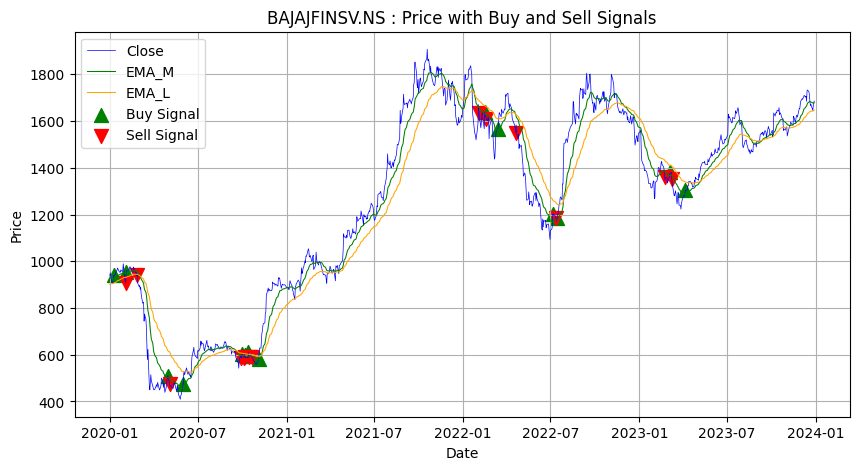

[*********************100%***********************]  1 of 1 completed



Order book for BEL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  3004 Shares are bought at ₹33.28333282470703 on 2020-01-14 00:00:00
SELL:  3004 Shares are sold at ₹30.216665267944336 on 2020-01-31 00:00:00
BUY:  3723 Shares are bought at ₹24.383333206176758 on 2020-03-27 00:00:00
SELL:  3723 Shares are sold at ₹24.200000762939453 on 2020-03-30 00:00:00
BUY:  3853 Shares are bought at ₹23.383333206176758 on 2020-04-09 00:00:00
SELL:  3853 Shares are sold at ₹22.483333587646484 on 2020-05-04 00:00:00
BUY:  3836 Shares are bought at ₹22.583332061767578 on 2020-05-15 00:00:00
SELL:  3836 Shares are sold at ₹21.5 on 2020-05-18 00:00:00
BUY:  3712 Shares are bought at ₹22.216665267944336 on 2020-05-27 00:00:00
316 97
SELL:  3712 Shares are sold at ₹43.349998474121094 on 2021-04-08 00:00:00
BUY:  3732 Shares are bought at ₹43.11666488647461 on 2021-04-26 00:00:00
763 326
SELL:  3732 Shares are sold at ₹100.6500015258789 on 2023-01-24 00:00:00
BU

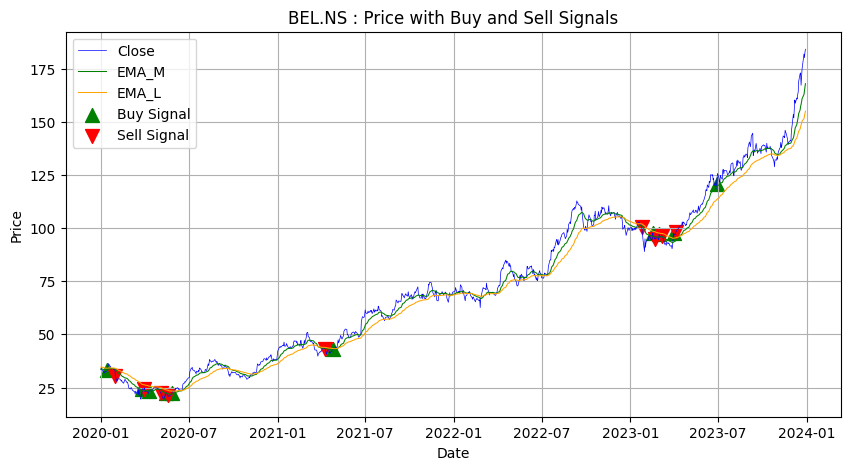

[*********************100%***********************]  1 of 1 completed



Order book for BPCL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  415 Shares are bought at ₹240.47500610351562 on 2020-01-28 00:00:00
SELL:  415 Shares are sold at ₹234.8249969482422 on 2020-01-30 00:00:00
BUY:  408 Shares are bought at ₹239.25 on 2020-02-04 00:00:00
SELL:  408 Shares are sold at ₹234.5 on 2020-02-13 00:00:00
BUY:  402 Shares are bought at ₹237.77499389648438 on 2020-02-19 00:00:00
SELL:  402 Shares are sold at ₹232.3249969482422 on 2020-02-24 00:00:00
BUY:  532 Shares are bought at ₹175.5500030517578 on 2020-04-07 00:00:00
SELL:  532 Shares are sold at ₹171.14999389648438 on 2020-04-08 00:00:00
BUY:  553 Shares are bought at ₹164.72500610351562 on 2020-05-27 00:00:00
SELL:  553 Shares are sold at ₹163.22500610351562 on 2020-05-28 00:00:00
BUY:  458 Shares are bought at ₹196.9499969482422 on 2020-07-16 00:00:00
SELL:  458 Shares are sold at ₹196.0749969482422 on 2020-09-22 00:00:00
BUY:  507 Shares are bought at ₹177.22500

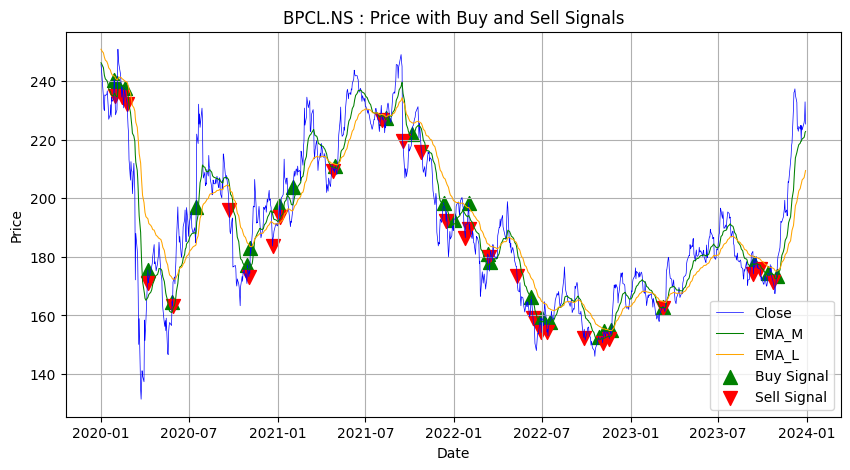

[*********************100%***********************]  1 of 1 completed



Order book for BHARTIARTL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  222 Shares are bought at ₹450.39385986328125 on 2020-01-08 00:00:00
SELL:  222 Shares are sold at ₹482.78570556640625 on 2020-03-13 00:00:00
BUY:  232 Shares are bought at ₹462.0254821777344 on 2020-03-26 00:00:00
SELL:  232 Shares are sold at ₹440.6763000488281 on 2020-03-27 00:00:00
BUY:  221 Shares are bought at ₹461.5346984863281 on 2020-04-07 00:00:00
SELL:  221 Shares are sold at ₹453.1422424316406 on 2020-04-08 00:00:00
BUY:  178 Shares are bought at ₹561.9003295898438 on 2020-06-04 00:00:00
SELL:  178 Shares are sold at ₹541.679931640625 on 2020-06-11 00:00:00
BUY:  174 Shares are bought at ₹553.066162109375 on 2020-06-17 00:00:00
SELL:  174 Shares are sold at ₹548.6981811523438 on 2020-06-25 00:00:00
BUY:  172 Shares are bought at ₹556.64892578125 on 2020-06-29 00:00:00
SELL:  172 Shares are sold at ₹552.3790893554688 on 2020-07-16 00:00:00
BUY:  168 Shares ar

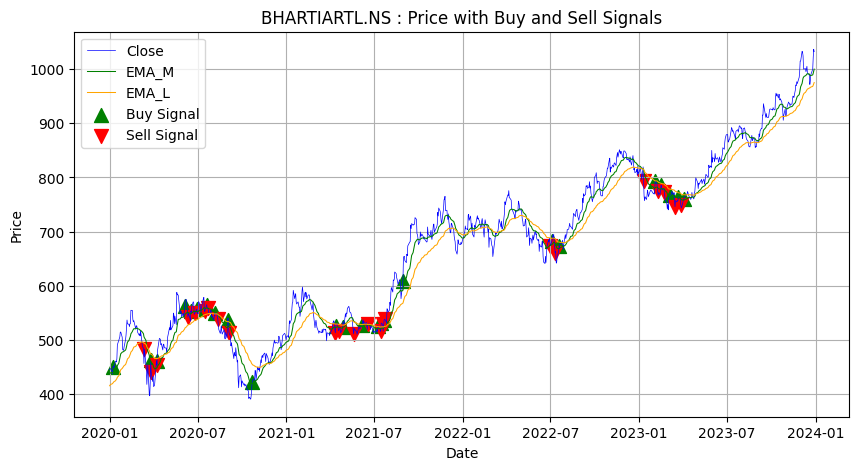

[*********************100%***********************]  1 of 1 completed



Order book for BRITANNIA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  32 Shares are bought at ₹3045.10009765625 on 2020-01-13 00:00:00
SELL:  32 Shares are sold at ₹3026.050048828125 on 2020-02-27 00:00:00
BUY:  31 Shares are bought at ₹3127.14990234375 on 2020-03-05 00:00:00
SELL:  31 Shares are sold at ₹3081.39990234375 on 2020-03-06 00:00:00
BUY:  36 Shares are bought at ₹2688.949951171875 on 2020-03-31 00:00:00
SELL:  36 Shares are sold at ₹2564.85009765625 on 2020-04-01 00:00:00
BUY:  32 Shares are bought at ₹2834.5 on 2020-04-07 00:00:00
SELL:  32 Shares are sold at ₹2775.550048828125 on 2020-04-08 00:00:00
BUY:  30 Shares are bought at ₹2994.64990234375 on 2020-05-08 00:00:00
261 85
SELL:  30 Shares are sold at ₹3609.050048828125 on 2021-01-15 00:00:00
BUY:  30 Shares are bought at ₹3630.800048828125 on 2021-01-21 00:00:00
SELL:  30 Shares are sold at ₹3501.10009765625 on 2021-01-29 00:00:00
BUY:  29 Shares are bought at ₹3580.0 on

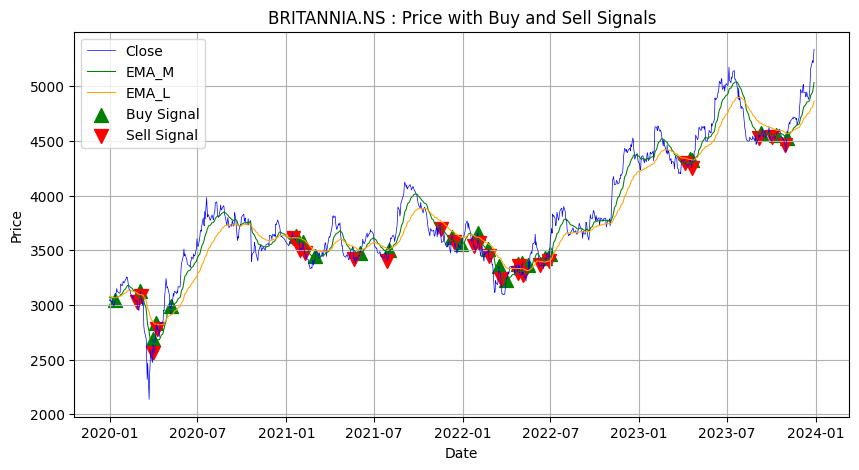

[*********************100%***********************]  1 of 1 completed



Order book for CIPLA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  212 Shares are bought at ₹470.1000061035156 on 2020-01-09 00:00:00
SELL:  212 Shares are sold at ₹465.1499938964844 on 2020-01-23 00:00:00
BUY:  221 Shares are bought at ₹447.6499938964844 on 2020-03-04 00:00:00
SELL:  221 Shares are sold at ₹440.6000061035156 on 2020-03-05 00:00:00
BUY:  238 Shares are bought at ₹407.6499938964844 on 2020-03-27 00:00:00
299 60
SELL:  238 Shares are sold at ₹805.9500122070312 on 2021-03-12 00:00:00
BUY:  242 Shares are bought at ₹792.9500122070312 on 2021-03-24 00:00:00
398 307
SELL:  242 Shares are sold at ₹911.2999877929688 on 2021-08-06 00:00:00
BUY:  240 Shares are bought at ₹917.6500244140625 on 2021-08-24 00:00:00
SELL:  240 Shares are sold at ₹916.0499877929688 on 2021-10-07 00:00:00
BUY:  238 Shares are bought at ₹922.5 on 2021-10-27 00:00:00
SELL:  238 Shares are sold at ₹891.75 on 2021-10-28 00:00:00
BUY:  233 Shares are bought at

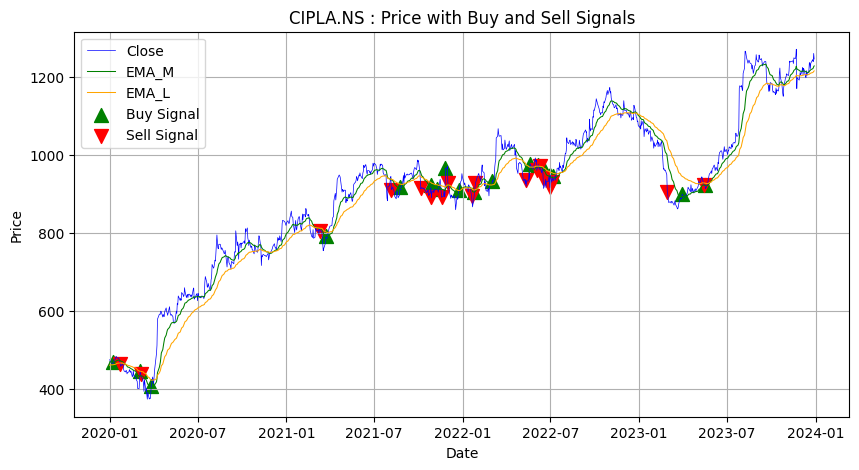

[*********************100%***********************]  1 of 1 completed



Order book for COALINDIA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  487 Shares are bought at ₹205.3000030517578 on 2020-01-10 00:00:00
SELL:  487 Shares are sold at ₹201.14999389648438 on 2020-01-20 00:00:00
BUY:  549 Shares are bought at ₹178.1999969482422 on 2020-03-03 00:00:00
SELL:  549 Shares are sold at ₹178.10000610351562 on 2020-03-04 00:00:00
BUY:  671 Shares are bought at ₹145.89999389648438 on 2020-04-13 00:00:00
SELL:  671 Shares are sold at ₹139.0 on 2020-04-21 00:00:00
BUY:  628 Shares are bought at ₹148.5 on 2020-04-30 00:00:00
SELL:  628 Shares are sold at ₹142.3000030517578 on 2020-05-04 00:00:00
BUY:  683 Shares are bought at ₹130.8000030517578 on 2020-05-27 00:00:00
SELL:  683 Shares are sold at ₹137.60000610351562 on 2020-06-18 00:00:00
BUY:  707 Shares are bought at ₹133.0 on 2020-07-20 00:00:00
SELL:  707 Shares are sold at ₹131.60000610351562 on 2020-07-24 00:00:00
BUY:  705 Shares are bought at ₹131.8500061035156

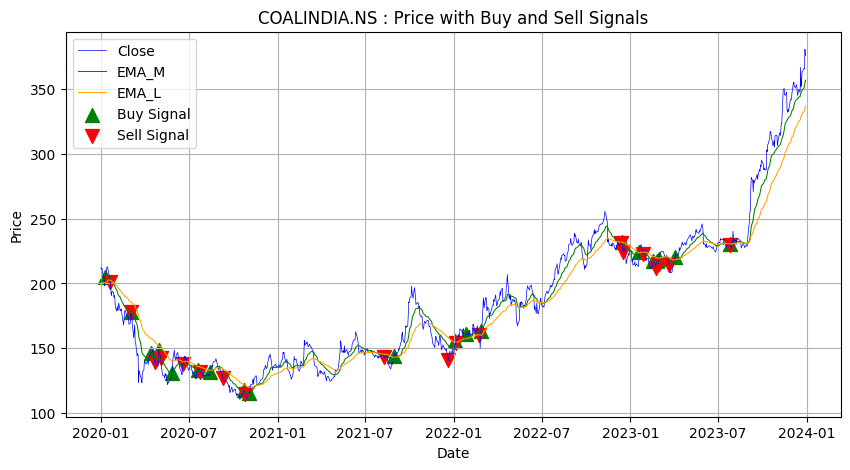

[*********************100%***********************]  1 of 1 completed



Order book for DRREDDY.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  31 Shares are bought at ₹3171.35009765625 on 2020-03-04 00:00:00
SELL:  31 Shares are sold at ₹3170.949951171875 on 2020-03-06 00:00:00
BUY:  34 Shares are bought at ₹2922.0 on 2020-03-25 00:00:00
SELL:  34 Shares are sold at ₹2916.5 on 2020-03-27 00:00:00
BUY:  33 Shares are bought at ₹2994.25 on 2020-03-30 00:00:00
427 61
SELL:  33 Shares are sold at ₹4774.9501953125 on 2021-09-20 00:00:00
BUY:  32 Shares are bought at ₹4853.64990234375 on 2021-09-21 00:00:00
SELL:  32 Shares are sold at ₹4791.64990234375 on 2021-09-27 00:00:00
BUY:  32 Shares are bought at ₹4833.14990234375 on 2021-09-28 00:00:00
SELL:  32 Shares are sold at ₹4753.89990234375 on 2021-10-20 00:00:00
BUY:  32 Shares are bought at ₹4801.4501953125 on 2021-11-01 00:00:00
SELL:  32 Shares are sold at ₹4788.75 on 2021-11-08 00:00:00
BUY:  32 Shares are bought at ₹4750.89990234375 on 2021-11-26 00:00:00
SELL:

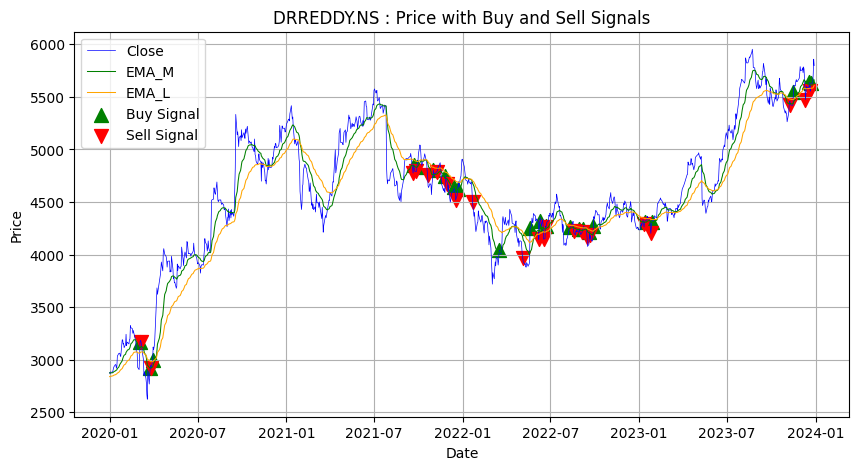

[*********************100%***********************]  1 of 1 completed



Order book for EICHERMOT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  46 Shares are bought at ₹2153.625 on 2020-01-16 00:00:00
SELL:  46 Shares are sold at ₹2129.219970703125 on 2020-01-17 00:00:00
BUY:  66 Shares are bought at ₹1477.0350341796875 on 2020-04-17 00:00:00
SELL:  66 Shares are sold at ₹1421.4449462890625 on 2020-04-20 00:00:00
BUY:  66 Shares are bought at ₹1432.68505859375 on 2020-04-28 00:00:00
SELL:  66 Shares are sold at ₹1374.8800048828125 on 2020-05-04 00:00:00
BUY:  63 Shares are bought at ₹1428.89501953125 on 2020-05-11 00:00:00
SELL:  63 Shares are sold at ₹1416.7049560546875 on 2020-05-12 00:00:00
BUY:  64 Shares are bought at ₹1408.760009765625 on 2020-05-21 00:00:00
SELL:  64 Shares are sold at ₹1392.239990234375 on 2020-05-22 00:00:00
BUY:  42 Shares are bought at ₹2113.469970703125 on 2020-08-17 00:00:00
SELL:  42 Shares are sold at ₹2064.35009765625 on 2020-09-22 00:00:00
BUY:  40 Shares are bought at ₹2180.94

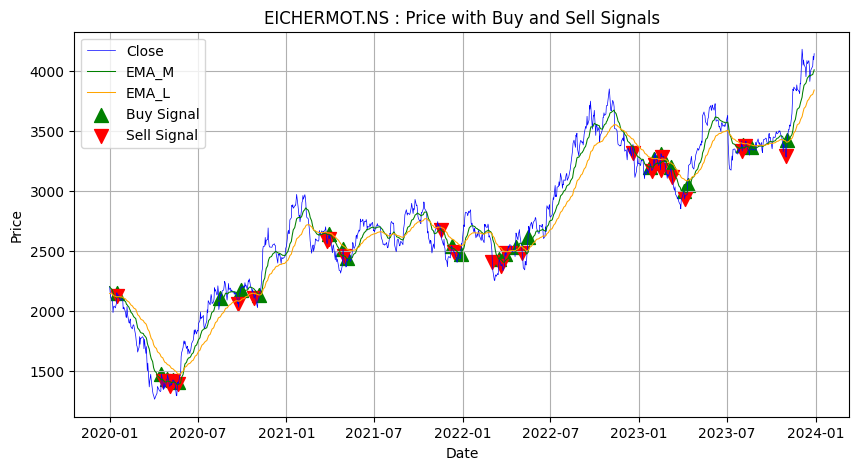

[*********************100%***********************]  1 of 1 completed



Order book for GRASIM.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  132 Shares are bought at ₹754.3007202148438 on 2020-01-09 00:00:00
SELL:  132 Shares are sold at ₹765.2073974609375 on 2020-01-17 00:00:00
BUY:  128 Shares are bought at ₹790.5565795898438 on 2020-02-04 00:00:00
SELL:  128 Shares are sold at ₹754.5497436523438 on 2020-02-10 00:00:00
BUY:  183 Shares are bought at ₹528.4487915039062 on 2020-04-09 00:00:00
SELL:  183 Shares are sold at ₹542.343505859375 on 2020-04-13 00:00:00
BUY:  197 Shares are bought at ₹502.4521484375 on 2020-05-11 00:00:00
SELL:  197 Shares are sold at ₹515.898681640625 on 2020-05-12 00:00:00
BUY:  200 Shares are bought at ₹509.8228454589844 on 2020-05-19 00:00:00
415 92
SELL:  200 Shares are sold at ₹1480.11474609375 on 2021-09-01 00:00:00
BUY:  198 Shares are bought at ₹1493.312255859375 on 2021-09-02 00:00:00
SELL:  198 Shares are sold at ₹1471.748046875 on 2022-03-04 00:00:00
BUY:  182 Shares are bo

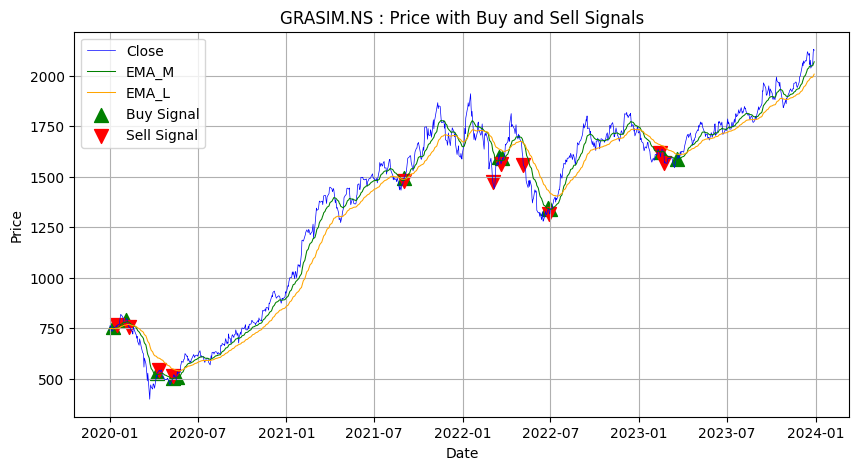

[*********************100%***********************]  1 of 1 completed



Order book for HCLTECH.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  167 Shares are bought at ₹595.5999755859375 on 2020-02-05 00:00:00
SELL:  167 Shares are sold at ₹582.4500122070312 on 2020-02-25 00:00:00
BUY:  211 Shares are bought at ₹463.1000061035156 on 2020-04-08 00:00:00
SELL:  211 Shares are sold at ₹455.25 on 2020-04-17 00:00:00
BUY:  204 Shares are bought at ₹470.0 on 2020-04-20 00:00:00
SELL:  204 Shares are sold at ₹455.70001220703125 on 2020-04-21 00:00:00
BUY:  201 Shares are bought at ₹462.3999938964844 on 2020-04-22 00:00:00
343 74
SELL:  201 Shares are sold at ₹924.4000244140625 on 2021-05-20 00:00:00
BUY:  199 Shares are bought at ₹930.6500244140625 on 2021-05-21 00:00:00
479 344
SELL:  199 Shares are sold at ₹1136.550048828125 on 2021-12-06 00:00:00
BUY:  193 Shares are bought at ₹1171.5999755859375 on 2021-12-08 00:00:00
SELL:  193 Shares are sold at ₹1162.3499755859375 on 2021-12-14 00:00:00
BUY:  194 Shares are boug

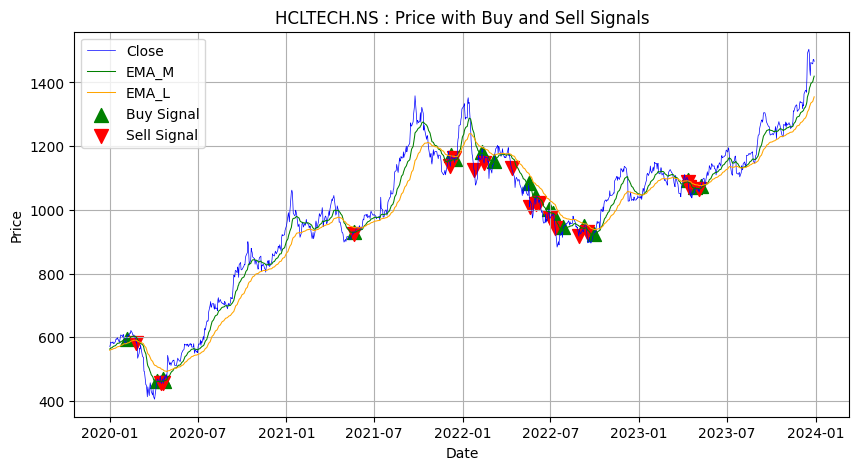

[*********************100%***********************]  1 of 1 completed



Order book for HDFCBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  78 Shares are bought at ₹1271.4000244140625 on 2020-01-09 00:00:00
SELL:  78 Shares are sold at ₹1244.3499755859375 on 2020-01-21 00:00:00
BUY:  78 Shares are bought at ₹1244.6500244140625 on 2020-02-05 00:00:00
SELL:  78 Shares are sold at ₹1219.3499755859375 on 2020-02-14 00:00:00
BUY:  103 Shares are bought at ₹925.0499877929688 on 2020-04-09 00:00:00
SELL:  103 Shares are sold at ₹895.3499755859375 on 2020-04-13 00:00:00
BUY:  98 Shares are bought at ₹944.8499755859375 on 2020-04-20 00:00:00
SELL:  98 Shares are sold at ₹921.6500244140625 on 2020-04-21 00:00:00
BUY:  95 Shares are bought at ₹946.4000244140625 on 2020-05-06 00:00:00
SELL:  95 Shares are sold at ₹925.0 on 2020-05-07 00:00:00
BUY:  97 Shares are bought at ₹903.6500244140625 on 2020-05-27 00:00:00
330 97
SELL:  97 Shares are sold at ₹1412.300048828125 on 2021-04-30 00:00:00
BUY:  95 Shares are bought at 

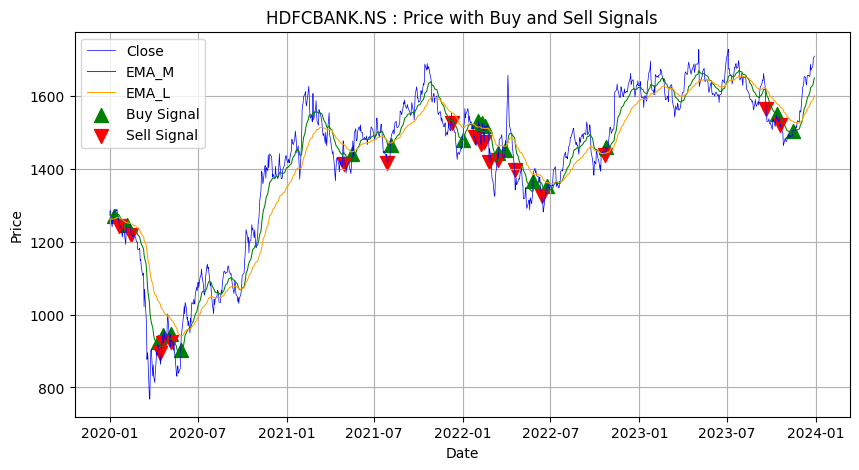

[*********************100%***********************]  1 of 1 completed



Order book for HDFCLIFE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  162 Shares are bought at ₹616.0 on 2020-01-23 00:00:00
SELL:  162 Shares are sold at ₹607.25 on 2020-01-24 00:00:00
BUY:  206 Shares are bought at ₹477.45001220703125 on 2020-03-26 00:00:00
SELL:  206 Shares are sold at ₹441.0 on 2020-03-27 00:00:00
BUY:  193 Shares are bought at ₹470.5 on 2020-04-07 00:00:00
SELL:  193 Shares are sold at ₹476.6000061035156 on 2020-04-08 00:00:00
BUY:  190 Shares are bought at ₹484.75 on 2020-04-27 00:00:00
SELL:  190 Shares are sold at ₹486.1499938964844 on 2020-04-28 00:00:00
BUY:  188 Shares are bought at ₹491.0 on 2020-05-06 00:00:00
SELL:  188 Shares are sold at ₹469.3500061035156 on 2020-05-18 00:00:00
BUY:  179 Shares are bought at ₹493.79998779296875 on 2020-05-21 00:00:00
191 94
SELL:  179 Shares are sold at ₹578.9500122070312 on 2020-10-07 00:00:00
BUY:  177 Shares are bought at ₹583.1500244140625 on 2020-10-08 00:00:00
SELL:  

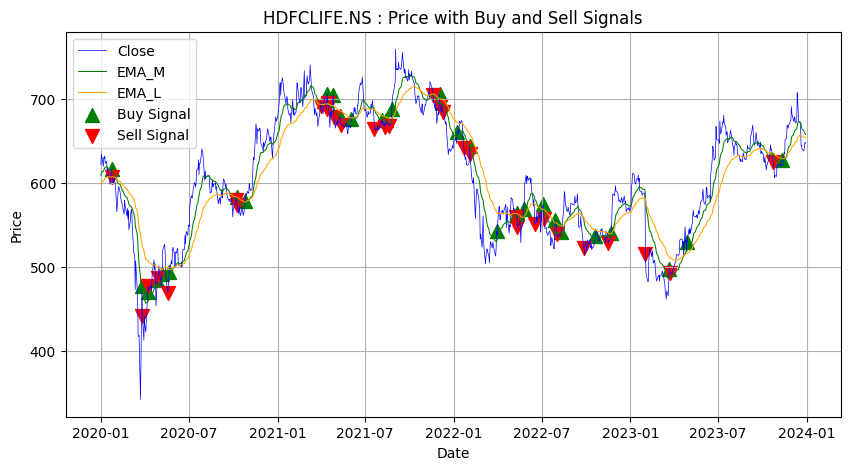

[*********************100%***********************]  1 of 1 completed



Order book for HEROMOTOCO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  41 Shares are bought at ₹2411.39990234375 on 2020-01-14 00:00:00
SELL:  41 Shares are sold at ₹2376.14990234375 on 2020-02-03 00:00:00
BUY:  40 Shares are bought at ₹2462.050048828125 on 2020-02-04 00:00:00
SELL:  40 Shares are sold at ₹2373.25 on 2020-02-05 00:00:00
BUY:  38 Shares are bought at ₹2443.449951171875 on 2020-02-07 00:00:00
SELL:  38 Shares are sold at ₹2385.699951171875 on 2020-02-10 00:00:00
BUY:  52 Shares are bought at ₹1769.199951171875 on 2020-04-07 00:00:00
SELL:  52 Shares are sold at ₹1821.6500244140625 on 2020-04-08 00:00:00
BUY:  52 Shares are bought at ₹1835.9000244140625 on 2020-04-17 00:00:00
SELL:  52 Shares are sold at ₹1805.8499755859375 on 2020-04-20 00:00:00
BUY:  51 Shares are bought at ₹1827.550048828125 on 2020-04-21 00:00:00
329 73
SELL:  51 Shares are sold at ₹2860.10009765625 on 2021-04-29 00:00:00
BUY:  50 Shares are bought at ₹2

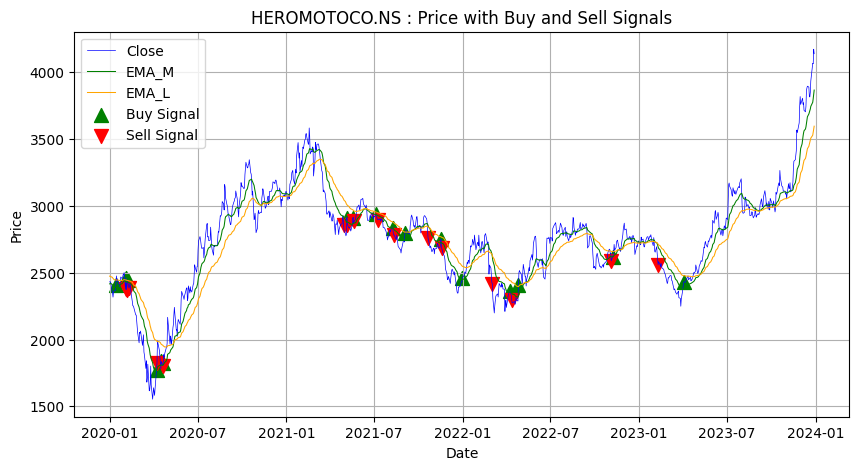

[*********************100%***********************]  1 of 1 completed



Order book for HINDALCO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  472 Shares are bought at ₹211.5 on 2020-01-10 00:00:00
SELL:  472 Shares are sold at ₹207.3000030517578 on 2020-01-20 00:00:00
BUY:  861 Shares are bought at ₹113.80000305175781 on 2020-04-13 00:00:00
SELL:  861 Shares are sold at ₹107.0999984741211 on 2020-04-21 00:00:00
BUY:  793 Shares are bought at ₹116.30000305175781 on 2020-04-29 00:00:00
489 79
SELL:  793 Shares are sold at ₹433.1000061035156 on 2021-12-20 00:00:00
BUY:  741 Shares are bought at ₹463.3500061035156 on 2021-12-22 00:00:00
SELL:  741 Shares are sold at ₹458.8999938964844 on 2021-12-24 00:00:00
BUY:  715 Shares are bought at ₹475.54998779296875 on 2021-12-31 00:00:00
SELL:  715 Shares are sold at ₹461.6499938964844 on 2022-05-04 00:00:00
BUY:  913 Shares are bought at ₹361.6499938964844 on 2022-07-07 00:00:00
SELL:  913 Shares are sold at ₹357.54998779296875 on 2022-07-08 00:00:00
BUY:  889 Shares are

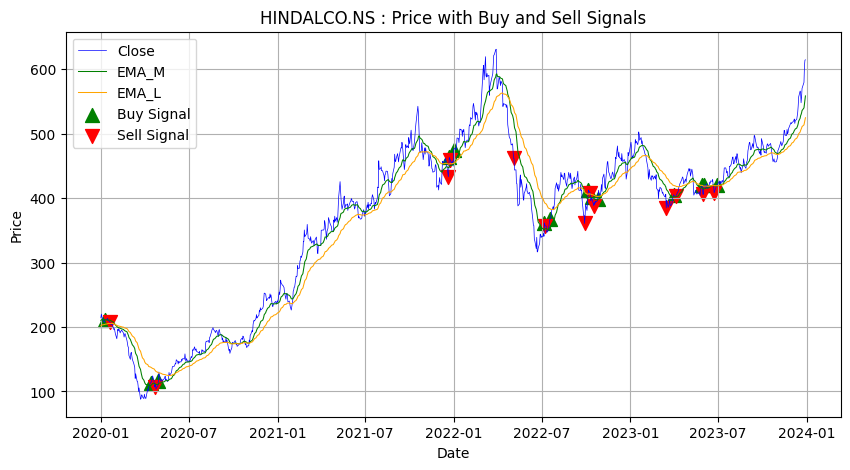

[*********************100%***********************]  1 of 1 completed



Order book for HINDUNILVR.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  51 Shares are bought at ₹1954.0 on 2020-01-10 00:00:00
SELL:  51 Shares are sold at ₹2033.199951171875 on 2020-03-13 00:00:00
BUY:  49 Shares are bought at ₹2088.14990234375 on 2020-03-25 00:00:00
SELL:  49 Shares are sold at ₹2041.5 on 2020-05-05 00:00:00
BUY:  49 Shares are bought at ₹2057.35009765625 on 2020-05-29 00:00:00
SELL:  49 Shares are sold at ₹2026.800048828125 on 2020-09-22 00:00:00
BUY:  47 Shares are bought at ₹2111.050048828125 on 2020-10-05 00:00:00
SELL:  47 Shares are sold at ₹2071.300048828125 on 2020-10-30 00:00:00
BUY:  46 Shares are bought at ₹2132.550048828125 on 2020-11-09 00:00:00
296 214
SELL:  46 Shares are sold at ₹2174.550048828125 on 2021-03-08 00:00:00
BUY:  45 Shares are bought at ₹2198.5 on 2021-03-09 00:00:00
400 297
SELL:  45 Shares are sold at ₹2381.800048828125 on 2021-08-10 00:00:00
BUY:  45 Shares are bought at ₹2390.449951171875

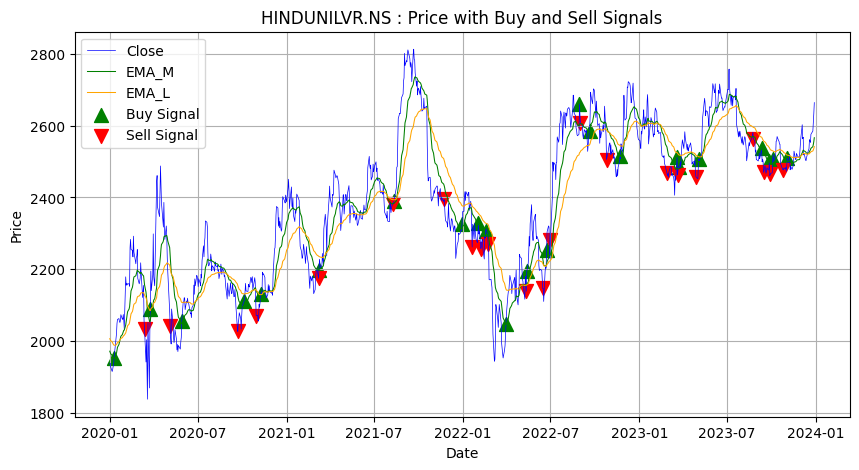

[*********************100%***********************]  1 of 1 completed



Order book for ICICIBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  183 Shares are bought at ₹546.2999877929688 on 2020-01-09 00:00:00
SELL:  183 Shares are sold at ₹537.5999755859375 on 2020-01-14 00:00:00
BUY:  183 Shares are bought at ₹534.8499755859375 on 2020-01-20 00:00:00
SELL:  183 Shares are sold at ₹522.8499755859375 on 2020-01-22 00:00:00
BUY:  180 Shares are bought at ₹533.8499755859375 on 2020-01-24 00:00:00
SELL:  180 Shares are sold at ₹525.6500244140625 on 2020-01-31 00:00:00
BUY:  178 Shares are bought at ₹530.7999877929688 on 2020-02-04 00:00:00
SELL:  178 Shares are sold at ₹515.3499755859375 on 2020-02-27 00:00:00
BUY:  244 Shares are bought at ₹375.54998779296875 on 2020-04-17 00:00:00
SELL:  244 Shares are sold at ₹361.29998779296875 on 2020-04-20 00:00:00
BUY:  250 Shares are bought at ₹352.95001220703125 on 2020-04-23 00:00:00
SELL:  250 Shares are sold at ₹334.8500061035156 on 2020-04-24 00:00:00
BUY:  233 Share

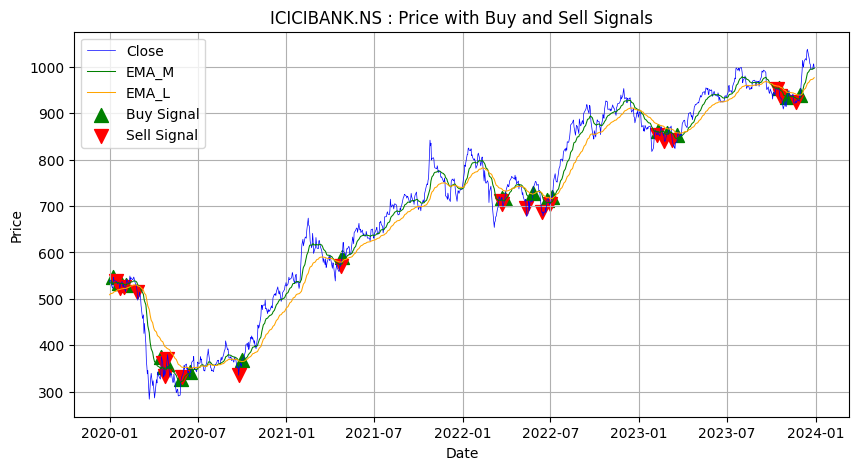

[*********************100%***********************]  1 of 1 completed



Order book for INDUSINDBK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  66 Shares are bought at ₹1507.6500244140625 on 2020-01-09 00:00:00
SELL:  66 Shares are sold at ₹1481.6500244140625 on 2020-01-14 00:00:00
BUY:  73 Shares are bought at ₹1334.25 on 2020-02-06 00:00:00
SELL:  73 Shares are sold at ₹1298.800048828125 on 2020-02-07 00:00:00
BUY:  204 Shares are bought at ₹468.04998779296875 on 2020-04-28 00:00:00
SELL:  204 Shares are sold at ₹471.1000061035156 on 2020-04-29 00:00:00
BUY:  211 Shares are bought at ₹454.3500061035156 on 2020-05-07 00:00:00
SELL:  211 Shares are sold at ₹440.3500061035156 on 2020-05-08 00:00:00
BUY:  209 Shares are bought at ₹446.20001220703125 on 2020-05-12 00:00:00
SELL:  209 Shares are sold at ₹428.0 on 2020-05-14 00:00:00
BUY:  218 Shares are bought at ₹410.1000061035156 on 2020-06-01 00:00:00
338 100
SELL:  218 Shares are sold at ₹916.6500244140625 on 2021-05-12 00:00:00
BUY:  209 Shares are bought at 

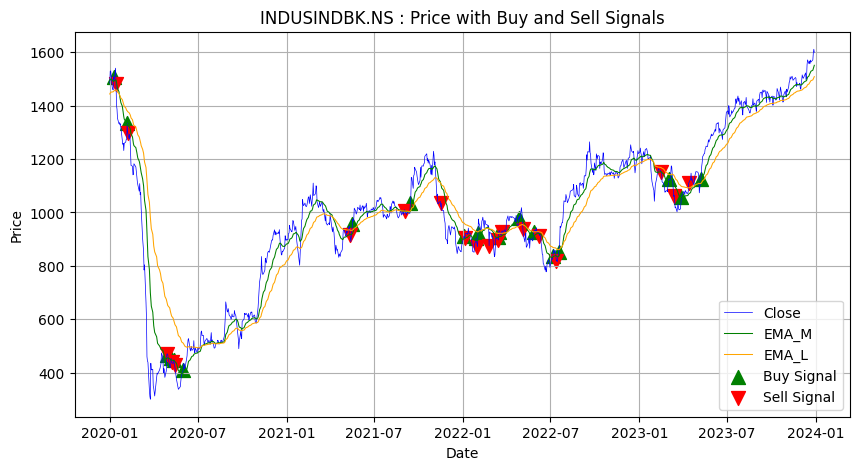

[*********************100%***********************]  1 of 1 completed



Order book for INFY.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  135 Shares are bought at ₹738.1500244140625 on 2020-01-10 00:00:00
SELL:  135 Shares are sold at ₹731.7000122070312 on 2020-02-28 00:00:00
BUY:  154 Shares are bought at ₹643.0 on 2020-03-26 00:00:00
SELL:  154 Shares are sold at ₹626.7000122070312 on 2020-03-30 00:00:00
BUY:  151 Shares are bought at ₹639.0 on 2020-04-07 00:00:00
SELL:  151 Shares are sold at ₹637.4000244140625 on 2020-04-13 00:00:00
BUY:  147 Shares are bought at ₹653.2999877929688 on 2020-04-20 00:00:00
SELL:  147 Shares are sold at ₹633.2000122070312 on 2020-04-21 00:00:00
BUY:  145 Shares are bought at ₹641.8499755859375 on 2020-04-22 00:00:00
527 74
SELL:  145 Shares are sold at ₹1721.3499755859375 on 2022-02-11 00:00:00
BUY:  143 Shares are bought at ₹1739.8499755859375 on 2022-03-07 00:00:00
SELL:  143 Shares are sold at ₹1621.4000244140625 on 2022-04-18 00:00:00
BUY:  152 Shares are bought at ₹1526.

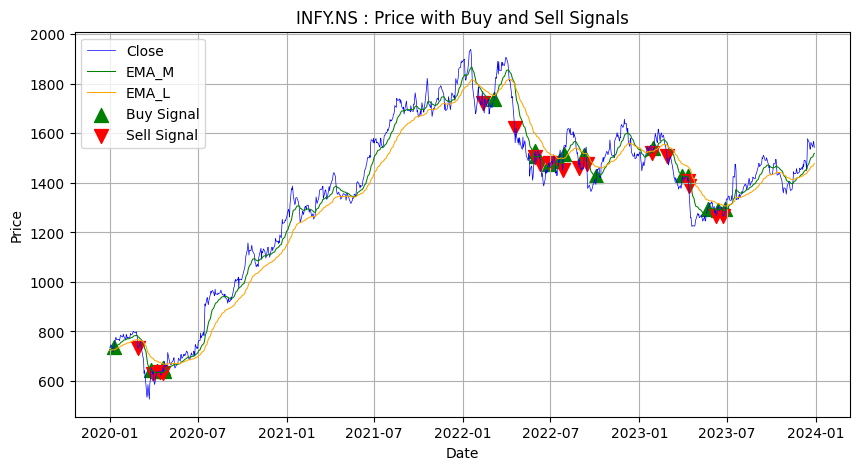

[*********************100%***********************]  1 of 1 completed



Order book for ITC.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  417 Shares are bought at ₹239.25 on 2020-01-13 00:00:00
SELL:  417 Shares are sold at ₹234.60000610351562 on 2020-01-27 00:00:00
BUY:  571 Shares are bought at ₹171.6999969482422 on 2020-03-31 00:00:00
SELL:  571 Shares are sold at ₹166.39999389648438 on 2020-04-01 00:00:00
BUY:  534 Shares are bought at ₹177.89999389648438 on 2020-04-03 00:00:00
SELL:  534 Shares are sold at ₹181.5500030517578 on 2020-04-07 00:00:00
BUY:  567 Shares are bought at ₹170.75 on 2020-05-19 00:00:00
SELL:  567 Shares are sold at ₹166.5500030517578 on 2020-09-24 00:00:00
BUY:  554 Shares are bought at ₹170.75 on 2020-10-23 00:00:00
SELL:  554 Shares are sold at ₹167.1999969482422 on 2020-10-27 00:00:00
BUY:  544 Shares are bought at ₹170.10000610351562 on 2020-11-03 00:00:00
337 210
SELL:  544 Shares are sold at ₹204.0 on 2021-05-11 00:00:00
BUY:  523 Shares are bought at ₹212.25 on 2021-05-14 00:0

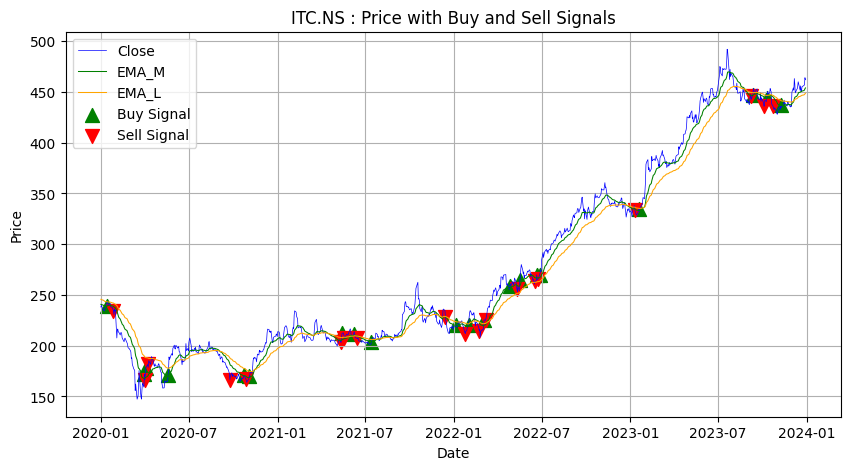

[*********************100%***********************]  1 of 1 completed



Order book for JSWSTEEL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  377 Shares are bought at ₹265.25 on 2020-01-07 00:00:00
SELL:  377 Shares are sold at ₹262.5 on 2020-01-08 00:00:00
BUY:  355 Shares are bought at ₹278.1000061035156 on 2020-01-09 00:00:00
SELL:  355 Shares are sold at ₹271.3500061035156 on 2020-01-20 00:00:00
BUY:  355 Shares are bought at ₹271.8999938964844 on 2020-01-24 00:00:00
SELL:  355 Shares are sold at ₹262.79998779296875 on 2020-01-27 00:00:00
BUY:  346 Shares are bought at ₹269.25 on 2020-02-05 00:00:00
SELL:  346 Shares are sold at ₹258.95001220703125 on 2020-02-24 00:00:00
BUY:  523 Shares are bought at ₹171.39999389648438 on 2020-04-15 00:00:00
SELL:  523 Shares are sold at ₹170.64999389648438 on 2020-04-16 00:00:00
BUY:  494 Shares are bought at ₹180.64999389648438 on 2020-04-30 00:00:00
SELL:  494 Shares are sold at ₹163.5500030517578 on 2020-05-04 00:00:00
BUY:  469 Shares are bought at ₹172.199996948242

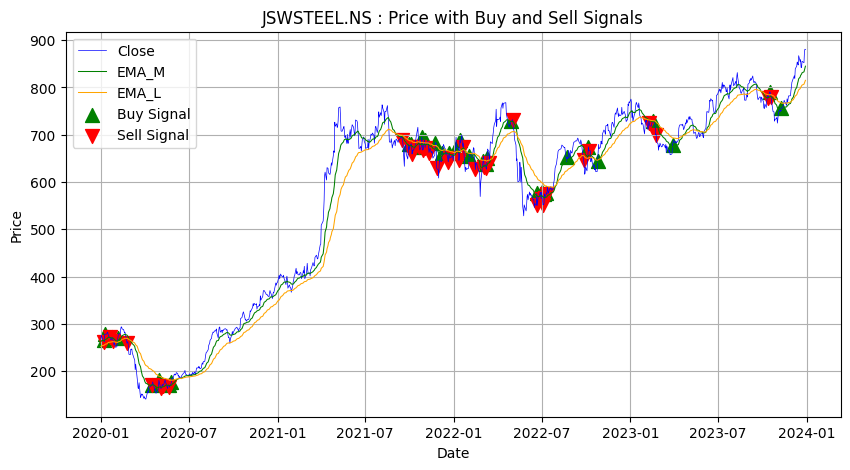

[*********************100%***********************]  1 of 1 completed



Order book for KOTAKBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  59 Shares are bought at ₹1684.699951171875 on 2020-01-10 00:00:00
SELL:  59 Shares are sold at ₹1617.9000244140625 on 2020-01-20 00:00:00
BUY:  56 Shares are bought at ₹1691.75 on 2020-01-31 00:00:00
SELL:  56 Shares are sold at ₹1676.25 on 2020-02-03 00:00:00
BUY:  57 Shares are bought at ₹1669.300048828125 on 2020-02-10 00:00:00
SELL:  57 Shares are sold at ₹1620.3499755859375 on 2020-02-28 00:00:00
BUY:  66 Shares are bought at ₹1399.0999755859375 on 2020-03-27 00:00:00
SELL:  66 Shares are sold at ₹1293.699951171875 on 2020-03-30 00:00:00
BUY:  68 Shares are bought at ₹1249.6500244140625 on 2020-04-23 00:00:00
SELL:  68 Shares are sold at ₹1239.550048828125 on 2020-04-24 00:00:00
BUY:  69 Shares are bought at ₹1217.550048828125 on 2020-05-27 00:00:00
197 97
SELL:  69 Shares are sold at ₹1309.550048828125 on 2020-10-15 00:00:00
BUY:  68 Shares are bought at ₹1336.550

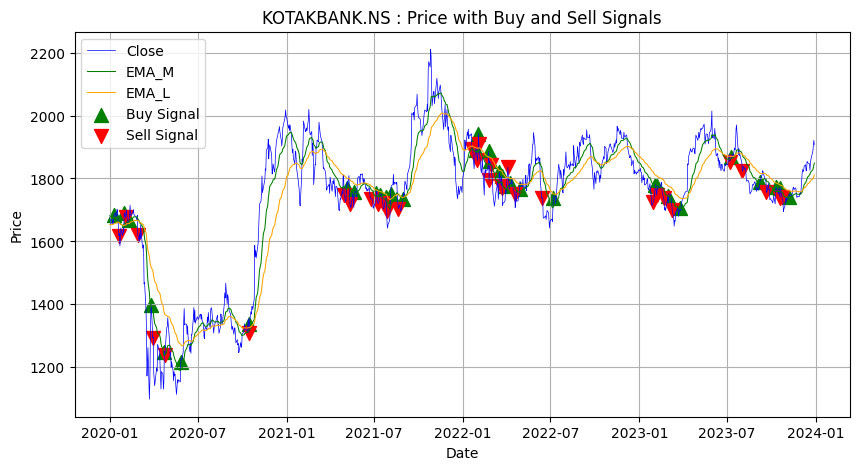

[*********************100%***********************]  1 of 1 completed



Order book for LT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  75 Shares are bought at ₹1316.1500244140625 on 2020-01-09 00:00:00
SELL:  75 Shares are sold at ₹1286.6500244140625 on 2020-02-03 00:00:00
BUY:  111 Shares are bought at ₹880.1500244140625 on 2020-04-15 00:00:00
SELL:  111 Shares are sold at ₹852.5999755859375 on 2020-04-22 00:00:00
BUY:  108 Shares are bought at ₹875.3499755859375 on 2020-04-29 00:00:00
SELL:  108 Shares are sold at ₹850.6500244140625 on 2020-05-04 00:00:00
BUY:  106 Shares are bought at ₹862.9000244140625 on 2020-05-13 00:00:00
SELL:  106 Shares are sold at ₹871.6500244140625 on 2020-05-14 00:00:00
BUY:  109 Shares are bought at ₹850.8499755859375 on 2020-05-27 00:00:00
143 97
SELL:  109 Shares are sold at ₹908.25 on 2020-07-30 00:00:00
BUY:  107 Shares are bought at ₹924.25 on 2020-08-04 00:00:00
SELL:  107 Shares are sold at ₹909.5 on 2020-09-09 00:00:00
BUY:  107 Shares are bought at ₹908.4500122070312 on

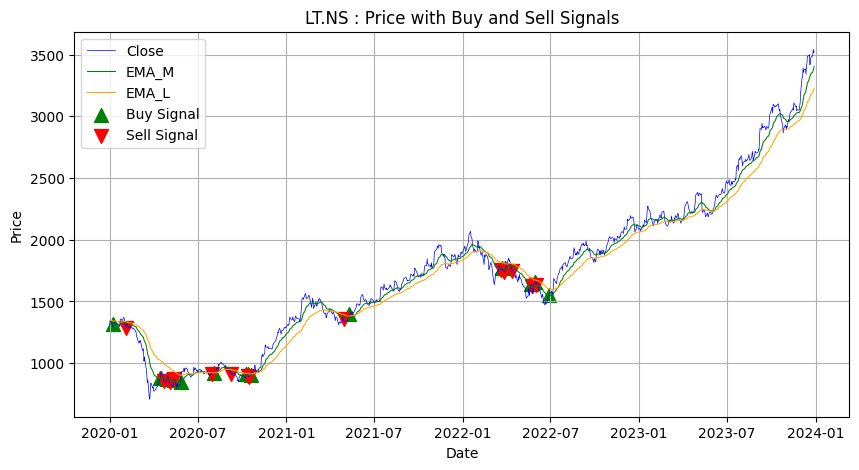

[*********************100%***********************]  1 of 1 completed



Order book for M&M.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  184 Shares are bought at ₹541.25 on 2020-01-09 00:00:00
SELL:  184 Shares are sold at ₹528.4000244140625 on 2020-02-10 00:00:00
BUY:  255 Shares are bought at ₹381.3999938964844 on 2020-04-09 00:00:00
SELL:  255 Shares are sold at ₹362.8500061035156 on 2020-04-13 00:00:00
BUY:  267 Shares are bought at ₹347.5 on 2020-04-23 00:00:00
SELL:  267 Shares are sold at ₹334.29998779296875 on 2020-04-24 00:00:00
BUY:  256 Shares are bought at ₹348.0 on 2020-04-29 00:00:00
320 79
SELL:  256 Shares are sold at ₹805.0999755859375 on 2021-04-15 00:00:00
BUY:  251 Shares are bought at ₹821.6500244140625 on 2021-04-16 00:00:00
SELL:  251 Shares are sold at ₹794.9500122070312 on 2021-04-19 00:00:00
BUY:  246 Shares are bought at ₹811.1500244140625 on 2021-04-20 00:00:00
SELL:  246 Shares are sold at ₹799.7000122070312 on 2021-04-22 00:00:00
BUY:  252 Shares are bought at ₹780.4500122070312 o

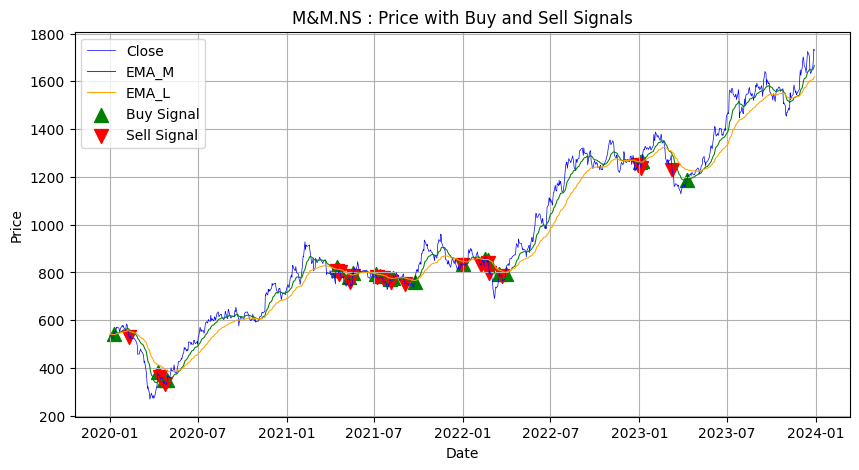

[*********************100%***********************]  1 of 1 completed



Order book for MARUTI.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  13 Shares are bought at ₹7227.89990234375 on 2020-01-09 00:00:00
SELL:  13 Shares are sold at ₹7148.7998046875 on 2020-01-27 00:00:00
BUY:  13 Shares are bought at ₹7199.60009765625 on 2020-02-04 00:00:00
SELL:  13 Shares are sold at ₹7040.89990234375 on 2020-02-05 00:00:00
BUY:  18 Shares are bought at ₹5326.64990234375 on 2020-04-09 00:00:00
SELL:  18 Shares are sold at ₹5283.14990234375 on 2020-04-13 00:00:00
BUY:  18 Shares are bought at ₹5180.85009765625 on 2020-04-22 00:00:00
SELL:  18 Shares are sold at ₹5156.35009765625 on 2020-04-23 00:00:00
BUY:  17 Shares are bought at ₹5358.7998046875 on 2020-04-30 00:00:00
SELL:  17 Shares are sold at ₹4886.2998046875 on 2020-05-04 00:00:00
BUY:  17 Shares are bought at ₹5036.10009765625 on 2020-05-13 00:00:00
SELL:  17 Shares are sold at ₹5114.0498046875 on 2020-05-14 00:00:00
BUY:  17 Shares are bought at ₹5050.10009765625 o

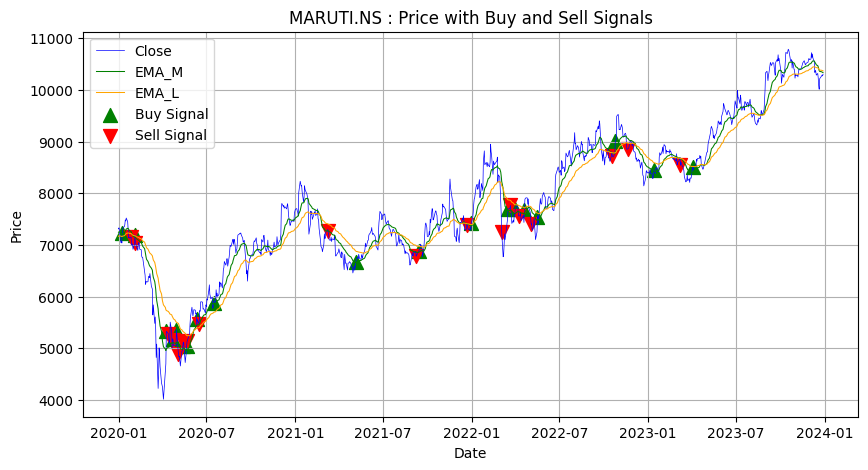

[*********************100%***********************]  1 of 1 completed



Order book for NESTLEIND.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  68 Shares are bought at ₹1464.344970703125 on 2020-01-09 00:00:00
SELL:  68 Shares are sold at ₹1499.1800537109375 on 2020-03-13 00:00:00
BUY:  68 Shares are bought at ₹1491.9649658203125 on 2020-03-26 00:00:00
169 59
SELL:  68 Shares are sold at ₹1623.260009765625 on 2020-09-04 00:00:00
BUY:  67 Shares are bought at ₹1640.3499755859375 on 2020-09-07 00:00:00
SELL:  67 Shares are sold at ₹1631.25 on 2020-09-09 00:00:00
BUY:  67 Shares are bought at ₹1642.0699462890625 on 2020-09-10 00:00:00
SELL:  67 Shares are sold at ₹1608.3299560546875 on 2020-09-14 00:00:00
BUY:  68 Shares are bought at ₹1591.864990234375 on 2020-09-30 00:00:00
SELL:  68 Shares are sold at ₹1567.3050537109375 on 2020-10-14 00:00:00
BUY:  66 Shares are bought at ₹1609.31494140625 on 2020-10-19 00:00:00
SELL:  66 Shares are sold at ₹1590.9449462890625 on 2020-10-22 00:00:00
BUY:  64 Shares are bought 

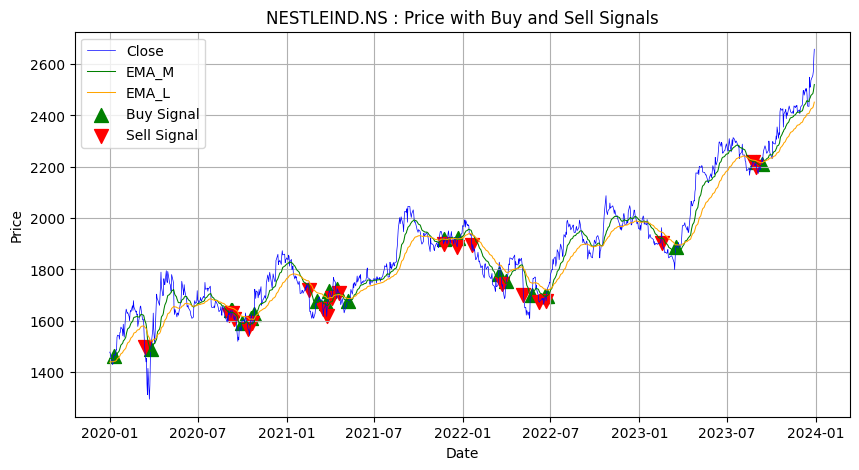

[*********************100%***********************]  1 of 1 completed



Order book for NTPC.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  865 Shares are bought at ₹115.5999984741211 on 2020-02-07 00:00:00
SELL:  865 Shares are sold at ₹113.5 on 2020-02-10 00:00:00
BUY:  840 Shares are bought at ₹116.8499984741211 on 2020-02-11 00:00:00
SELL:  840 Shares are sold at ₹112.69999694824219 on 2020-02-14 00:00:00
BUY:  1087 Shares are bought at ₹87.0999984741211 on 2020-04-09 00:00:00
SELL:  1087 Shares are sold at ₹88.6500015258789 on 2020-04-13 00:00:00
BUY:  1014 Shares are bought at ₹95.05000305175781 on 2020-04-30 00:00:00
SELL:  1014 Shares are sold at ₹91.44999694824219 on 2020-05-04 00:00:00
BUY:  1001 Shares are bought at ₹92.5999984741211 on 2020-05-05 00:00:00
SELL:  1001 Shares are sold at ₹90.44999694824219 on 2020-05-07 00:00:00
BUY:  988 Shares are bought at ₹91.6500015258789 on 2020-05-12 00:00:00
SELL:  988 Shares are sold at ₹89.3499984741211 on 2020-05-14 00:00:00
BUY:  969 Shares are bought at ₹9

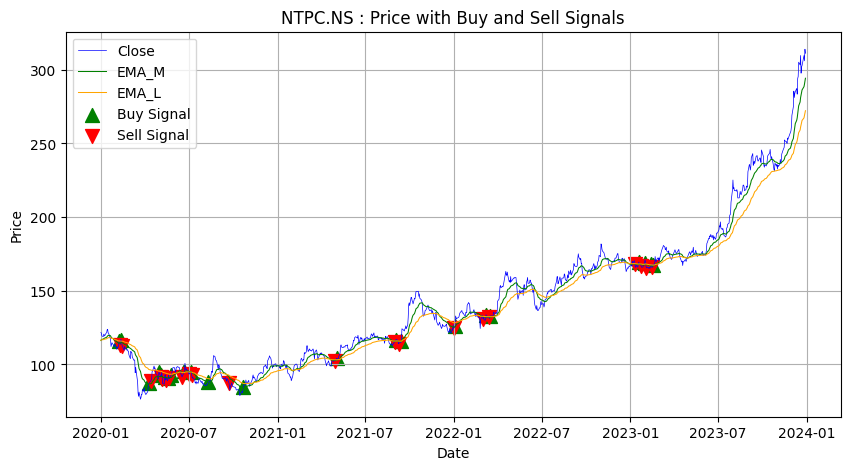

[*********************100%***********************]  1 of 1 completed



Order book for ONGC.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  1371 Shares are bought at ₹72.9000015258789 on 2020-04-07 00:00:00
SELL:  1371 Shares are sold at ₹74.44999694824219 on 2020-04-08 00:00:00
BUY:  1278 Shares are bought at ₹79.9000015258789 on 2020-04-30 00:00:00
SELL:  1278 Shares are sold at ₹76.55000305175781 on 2020-05-04 00:00:00
BUY:  1268 Shares are bought at ₹77.1500015258789 on 2020-05-19 00:00:00
SELL:  1268 Shares are sold at ₹76.1500015258789 on 2020-05-22 00:00:00
BUY:  1147 Shares are bought at ₹84.1500015258789 on 2020-06-26 00:00:00
SELL:  1147 Shares are sold at ₹82.4000015258789 on 2020-06-29 00:00:00
BUY:  1129 Shares are bought at ₹83.75 on 2020-07-06 00:00:00
SELL:  1129 Shares are sold at ₹81.94999694824219 on 2020-07-07 00:00:00
BUY:  1122 Shares are bought at ₹82.44999694824219 on 2020-07-21 00:00:00
SELL:  1122 Shares are sold at ₹81.0 on 2020-07-24 00:00:00
BUY:  1146 Shares are bought at ₹79.300003

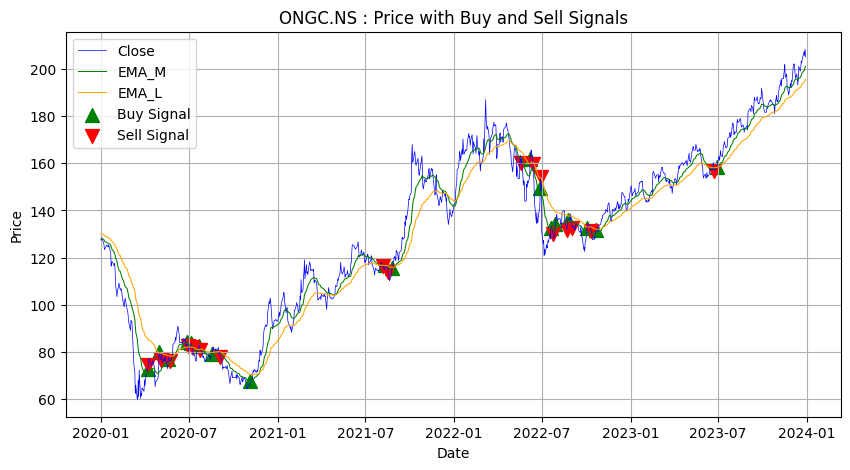

[*********************100%***********************]  1 of 1 completed



Order book for POWERGRID.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  914 Shares are bought at ₹109.3218994140625 on 2020-02-04 00:00:00
SELL:  914 Shares are sold at ₹106.5093994140625 on 2020-02-05 00:00:00
BUY:  903 Shares are bought at ₹107.8312759399414 on 2020-03-03 00:00:00
SELL:  903 Shares are sold at ₹101.7844009399414 on 2020-03-09 00:00:00
BUY:  994 Shares are bought at ₹92.5031509399414 on 2020-04-09 00:00:00
SELL:  994 Shares are sold at ₹89.97189331054688 on 2020-04-13 00:00:00
BUY:  973 Shares are bought at ₹91.91252136230469 on 2020-04-16 00:00:00
SELL:  973 Shares are sold at ₹91.23751831054688 on 2020-04-22 00:00:00
BUY:  974 Shares are bought at ₹91.15314483642578 on 2020-04-30 00:00:00
SELL:  974 Shares are sold at ₹89.46564483642578 on 2020-05-04 00:00:00
BUY:  946 Shares are bought at ₹92.05314636230469 on 2020-05-05 00:00:00
SELL:  946 Shares are sold at ₹89.4375228881836 on 2020-05-08 00:00:00
BUY:  921 Shares are

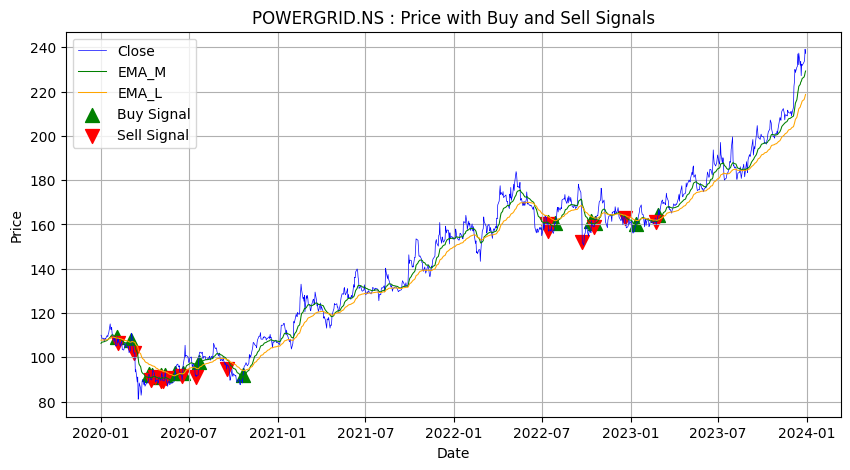

[*********************100%***********************]  1 of 1 completed



Order book for RELIANCE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  70 Shares are bought at ₹1415.3870849609375 on 2020-01-09 00:00:00
SELL:  70 Shares are sold at ₹1377.4879150390625 on 2020-01-27 00:00:00
BUY:  72 Shares are bought at ₹1347.863525390625 on 2020-02-13 00:00:00
SELL:  72 Shares are sold at ₹1321.1650390625 on 2020-02-24 00:00:00
BUY:  93 Shares are bought at ₹1018.3380737304688 on 2020-03-31 00:00:00
SELL:  93 Shares are sold at ₹987.8908081054688 on 2020-04-01 00:00:00
BUY:  83 Shares are bought at ₹1102.7767333984375 on 2020-04-07 00:00:00
SELL:  83 Shares are sold at ₹1090.021728515625 on 2020-04-08 00:00:00
BUY:  69 Shares are bought at ₹1323.3046875 on 2020-05-20 00:00:00
216 93
SELL:  69 Shares are sold at ₹1843.4149169921875 on 2020-11-11 00:00:00
BUY:  69 Shares are bought at ₹1840.2305908203125 on 2020-12-08 00:00:00
SELL:  69 Shares are sold at ₹1790.342529296875 on 2020-12-21 00:00:00
BUY:  67 Shares are bough

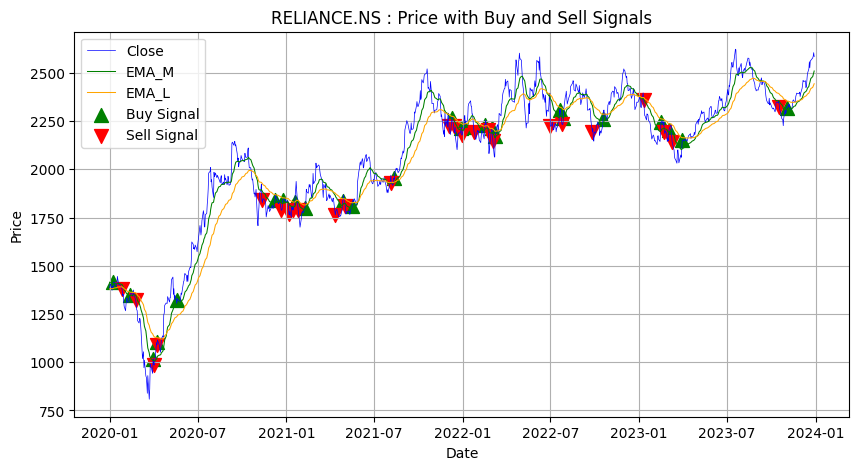

[*********************100%***********************]  1 of 1 completed



Order book for SBILIFE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  101 Shares are bought at ₹985.9500122070312 on 2020-01-23 00:00:00
SELL:  101 Shares are sold at ₹912.6500244140625 on 2020-02-03 00:00:00
BUY:  125 Shares are bought at ₹735.2999877929688 on 2020-04-07 00:00:00
SELL:  125 Shares are sold at ₹707.75 on 2020-04-13 00:00:00
BUY:  126 Shares are bought at ₹702.4500122070312 on 2020-04-17 00:00:00
SELL:  126 Shares are sold at ₹671.2999877929688 on 2020-04-21 00:00:00
BUY:  120 Shares are bought at ₹704.7999877929688 on 2020-04-22 00:00:00
SELL:  120 Shares are sold at ₹679.1500244140625 on 2020-04-24 00:00:00
BUY:  115 Shares are bought at ₹714.0999755859375 on 2020-04-27 00:00:00
SELL:  115 Shares are sold at ₹687.6500244140625 on 2020-05-04 00:00:00
BUY:  110 Shares are bought at ₹713.5499877929688 on 2020-05-05 00:00:00
SELL:  110 Shares are sold at ₹700.75 on 2020-05-18 00:00:00
BUY:  106 Shares are bought at ₹730.400024

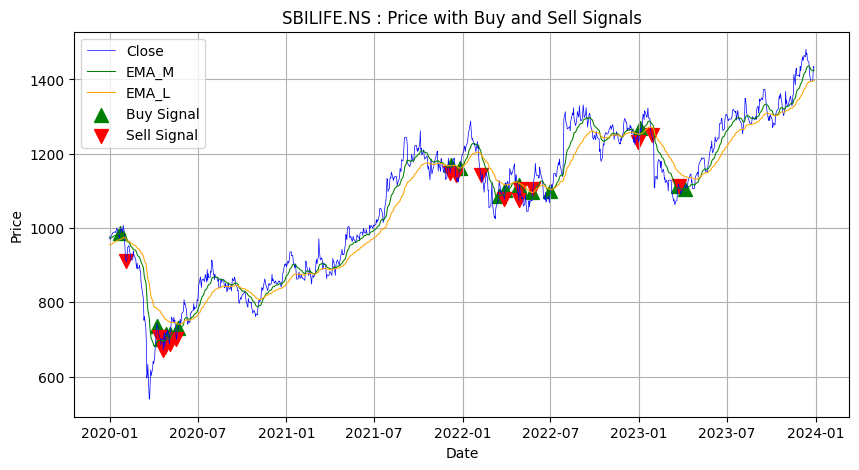

[*********************100%***********************]  1 of 1 completed



Order book for SHRIRAMFIN.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  89 Shares are bought at ₹1117.680419921875 on 2020-01-09 00:00:00
SELL:  89 Shares are sold at ₹1103.357421875 on 2020-01-14 00:00:00
BUY:  91 Shares are bought at ₹1078.8524169921875 on 2020-01-29 00:00:00
SELL:  91 Shares are sold at ₹1016.8836059570312 on 2020-01-30 00:00:00
BUY:  84 Shares are bought at ₹1103.893310546875 on 2020-02-05 00:00:00
SELL:  84 Shares are sold at ₹1076.9525146484375 on 2020-03-06 00:00:00
BUY:  116 Shares are bought at ₹781.4798583984375 on 2020-04-17 00:00:00
SELL:  116 Shares are sold at ₹667.4805908203125 on 2020-04-20 00:00:00
BUY:  114 Shares are bought at ₹677.4677124023438 on 2020-04-28 00:00:00
SELL:  114 Shares are sold at ₹652.9140014648438 on 2020-05-12 00:00:00
BUY:  124 Shares are bought at ₹601.0297241210938 on 2020-06-03 00:00:00
SELL:  124 Shares are sold at ₹599.1296997070312 on 2020-06-05 00:00:00
BUY:  108 Shares are bo

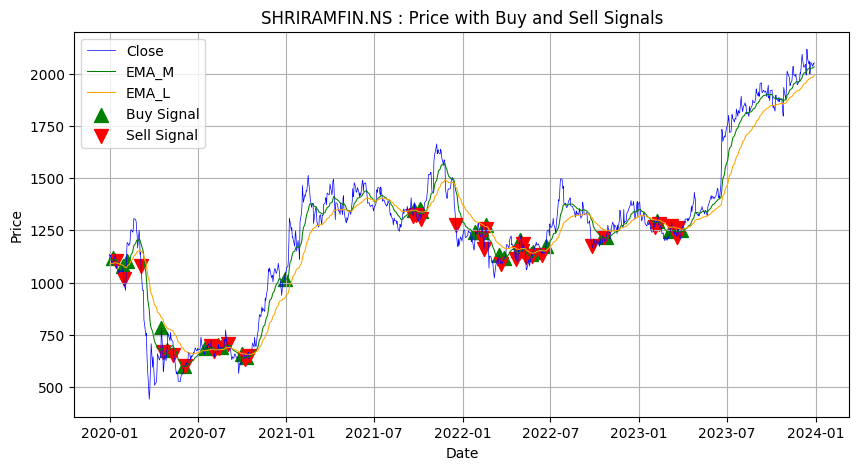

[*********************100%***********************]  1 of 1 completed



Order book for SBIN.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  302 Shares are bought at ₹330.20001220703125 on 2020-01-09 00:00:00
SELL:  302 Shares are sold at ₹324.25 on 2020-01-15 00:00:00
BUY:  303 Shares are bought at ₹324.04998779296875 on 2020-01-24 00:00:00
SELL:  303 Shares are sold at ₹316.20001220703125 on 2020-01-27 00:00:00
BUY:  297 Shares are bought at ₹321.95001220703125 on 2020-02-06 00:00:00
SELL:  297 Shares are sold at ₹314.20001220703125 on 2020-02-17 00:00:00
BUY:  291 Shares are bought at ₹320.3500061035156 on 2020-02-19 00:00:00
SELL:  291 Shares are sold at ₹303.0 on 2020-02-28 00:00:00
BUY:  520 Shares are bought at ₹170.0500030517578 on 2020-06-01 00:00:00
131 100
SELL:  520 Shares are sold at ₹186.0500030517578 on 2020-07-14 00:00:00
BUY:  519 Shares are bought at ₹186.25 on 2020-07-16 00:00:00
SELL:  519 Shares are sold at ₹186.1999969482422 on 2020-09-22 00:00:00
BUY:  505 Shares are bought at ₹191.60000610

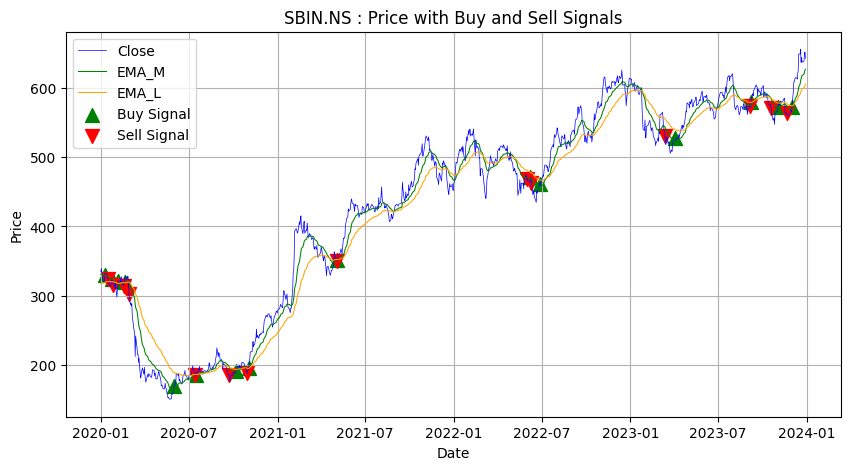

[*********************100%***********************]  1 of 1 completed



Order book for SUNPHARMA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  246 Shares are bought at ₹405.45001220703125 on 2020-03-04 00:00:00
SELL:  246 Shares are sold at ₹400.8999938964844 on 2020-03-06 00:00:00
BUY:  263 Shares are bought at ₹375.95001220703125 on 2020-04-03 00:00:00
215 64
SELL:  263 Shares are sold at ₹490.8999938964844 on 2020-11-10 00:00:00
BUY:  255 Shares are bought at ₹506.04998779296875 on 2020-11-11 00:00:00
487 216
SELL:  255 Shares are sold at ₹764.4500122070312 on 2021-12-16 00:00:00
BUY:  253 Shares are bought at ₹768.9500122070312 on 2021-12-17 00:00:00
SELL:  253 Shares are sold at ₹763.9500122070312 on 2021-12-20 00:00:00
BUY:  248 Shares are bought at ₹778.5499877929688 on 2021-12-21 00:00:00
621 490
SELL:  248 Shares are sold at ₹830.5999755859375 on 2022-06-30 00:00:00
BUY:  247 Shares are bought at ₹835.7999877929688 on 2022-07-05 00:00:00
826 624
SELL:  247 Shares are sold at ₹973.0499877929688 on 2023

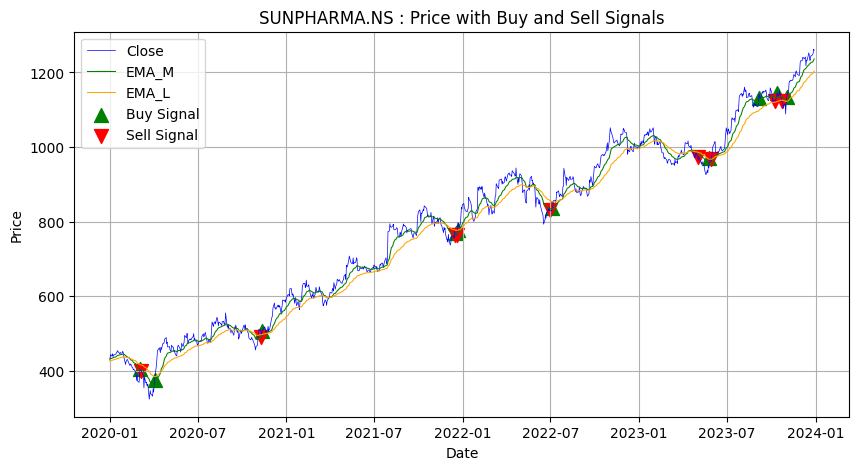

[*********************100%***********************]  1 of 1 completed



Order book for TCS.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  45 Shares are bought at ₹2206.89990234375 on 2020-01-22 00:00:00
SELL:  45 Shares are sold at ₹2183.75 on 2020-01-28 00:00:00
BUY:  45 Shares are bought at ₹2161.949951171875 on 2020-02-10 00:00:00
SELL:  45 Shares are sold at ₹2115.35009765625 on 2020-02-24 00:00:00
BUY:  45 Shares are bought at ₹2125.050048828125 on 2020-03-05 00:00:00
SELL:  45 Shares are sold at ₹2116.449951171875 on 2020-03-06 00:00:00
BUY:  53 Shares are bought at ₹1806.199951171875 on 2020-04-17 00:00:00
SELL:  53 Shares are sold at ₹1737.6500244140625 on 2020-04-21 00:00:00
BUY:  49 Shares are bought at ₹1878.25 on 2020-04-23 00:00:00
SELL:  49 Shares are sold at ₹1818.550048828125 on 2020-04-24 00:00:00
BUY:  44 Shares are bought at ₹2035.300048828125 on 2020-06-23 00:00:00
467 116
SELL:  44 Shares are sold at ₹3521.89990234375 on 2021-11-17 00:00:00
BUY:  44 Shares are bought at ₹3502.0 on 2021-11-2

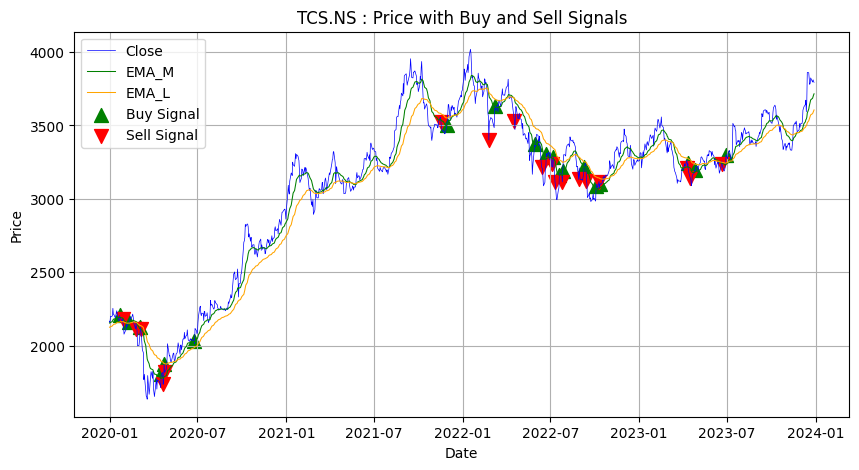

[*********************100%***********************]  1 of 1 completed



Order book for TATACONSUM.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  304 Shares are bought at ₹328.54998779296875 on 2020-01-09 00:00:00
SELL:  304 Shares are sold at ₹330.1000061035156 on 2020-03-09 00:00:00
BUY:  341 Shares are bought at ₹294.3999938964844 on 2020-04-08 00:00:00
500 66
SELL:  341 Shares are sold at ₹738.8499755859375 on 2022-01-04 00:00:00
BUY:  341 Shares are bought at ₹738.6500244140625 on 2022-01-11 00:00:00
SELL:  341 Shares are sold at ₹730.2000122070312 on 2022-01-13 00:00:00
BUY:  326 Shares are bought at ₹762.5 on 2022-01-14 00:00:00
SELL:  326 Shares are sold at ₹731.4500122070312 on 2022-01-18 00:00:00
BUY:  328 Shares are bought at ₹727.2999877929688 on 2022-01-31 00:00:00
SELL:  328 Shares are sold at ₹704.7999877929688 on 2022-02-07 00:00:00
BUY:  321 Shares are bought at ₹720.3499755859375 on 2022-02-17 00:00:00
SELL:  321 Shares are sold at ₹713.2000122070312 on 2022-02-21 00:00:00
BUY:  320 Shares are 

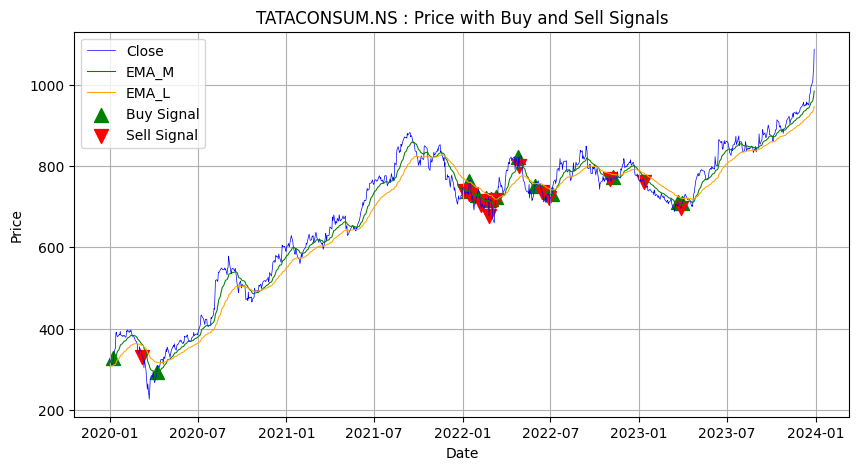

[*********************100%***********************]  1 of 1 completed



Order book for TATAMOTORS.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  531 Shares are bought at ₹188.0500030517578 on 2020-01-29 00:00:00
SELL:  531 Shares are sold at ₹186.1999969482422 on 2020-01-30 00:00:00
BUY:  538 Shares are bought at ₹183.75 on 2020-02-05 00:00:00
SELL:  538 Shares are sold at ₹178.85000610351562 on 2020-02-06 00:00:00
BUY:  1198 Shares are bought at ₹80.44999694824219 on 2020-04-20 00:00:00
SELL:  1198 Shares are sold at ₹74.6500015258789 on 2020-04-21 00:00:00
BUY:  1144 Shares are bought at ₹78.1500015258789 on 2020-04-29 00:00:00
405 79
SELL:  1144 Shares are sold at ₹297.70001220703125 on 2021-08-17 00:00:00
BUY:  1153 Shares are bought at ₹295.25 on 2021-09-01 00:00:00
553 415
SELL:  1153 Shares are sold at ₹435.79998779296875 on 2022-03-23 00:00:00
BUY:  1153 Shares are bought at ₹435.6499938964844 on 2022-03-30 00:00:00
SELL:  1153 Shares are sold at ₹433.79998779296875 on 2022-04-18 00:00:00
BUY:  1136 Sha

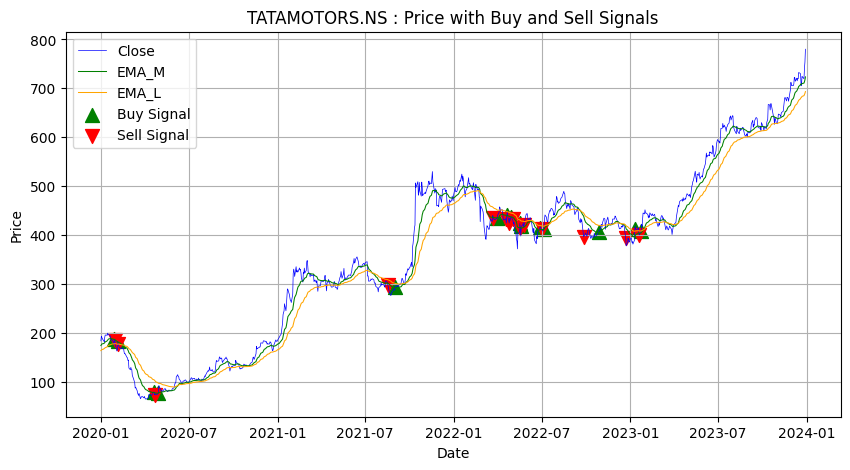

[*********************100%***********************]  1 of 1 completed



Order book for TATASTEEL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  2082 Shares are bought at ₹48.025001525878906 on 2020-01-23 00:00:00
SELL:  2082 Shares are sold at ₹46.244998931884766 on 2020-01-27 00:00:00
BUY:  2027 Shares are bought at ₹47.505001068115234 on 2020-02-05 00:00:00
SELL:  2027 Shares are sold at ₹44.380001068115234 on 2020-02-10 00:00:00
BUY:  3066 Shares are bought at ₹29.334999084472656 on 2020-04-17 00:00:00
SELL:  3066 Shares are sold at ₹28.639999389648438 on 2020-04-20 00:00:00
BUY:  3107 Shares are bought at ₹28.264999389648438 on 2020-04-29 00:00:00
SELL:  3107 Shares are sold at ₹27.360000610351562 on 2020-05-04 00:00:00
BUY:  3002 Shares are bought at ₹28.31999969482422 on 2020-05-20 00:00:00
SELL:  3002 Shares are sold at ₹27.44499969482422 on 2020-05-22 00:00:00
BUY:  2937 Shares are bought at ₹28.045000076293945 on 2020-05-26 00:00:00
190 96
SELL:  2937 Shares are sold at ₹37.7400016784668 on 2020-10-06 

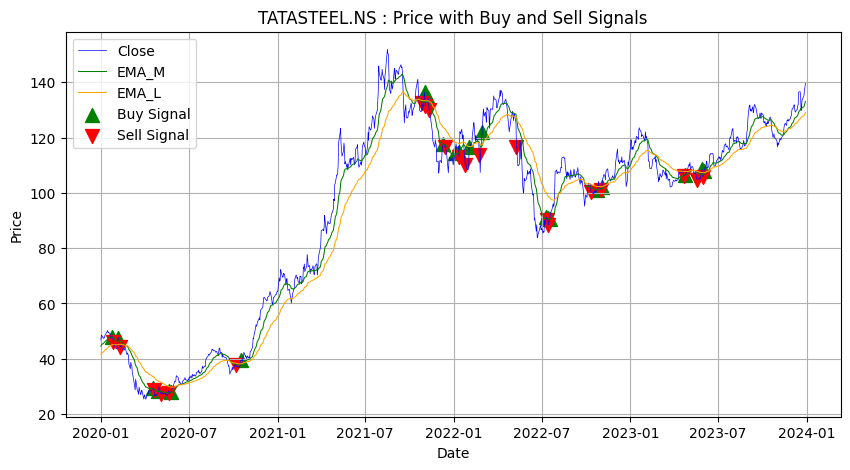

[*********************100%***********************]  1 of 1 completed



Order book for TECHM.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  129 Shares are bought at ₹773.6500244140625 on 2020-01-09 00:00:00
SELL:  129 Shares are sold at ₹744.4000244140625 on 2020-02-28 00:00:00
BUY:  176 Shares are bought at ₹546.25 on 2020-04-30 00:00:00
SELL:  176 Shares are sold at ₹502.45001220703125 on 2020-05-04 00:00:00
BUY:  165 Shares are bought at ₹536.2000122070312 on 2020-05-08 00:00:00
SELL:  165 Shares are sold at ₹533.25 on 2020-05-12 00:00:00
BUY:  166 Shares are bought at ₹529.6500244140625 on 2020-05-22 00:00:00
SELL:  166 Shares are sold at ₹520.4500122070312 on 2020-05-26 00:00:00
BUY:  165 Shares are bought at ₹523.75 on 2020-05-27 00:00:00
337 97
SELL:  165 Shares are sold at ₹977.0499877929688 on 2021-05-11 00:00:00
BUY:  164 Shares are bought at ₹977.6500244140625 on 2021-05-19 00:00:00
542 342
SELL:  164 Shares are sold at ₹1424.0999755859375 on 2022-03-07 00:00:00
BUY:  160 Shares are bought at ₹1461.9

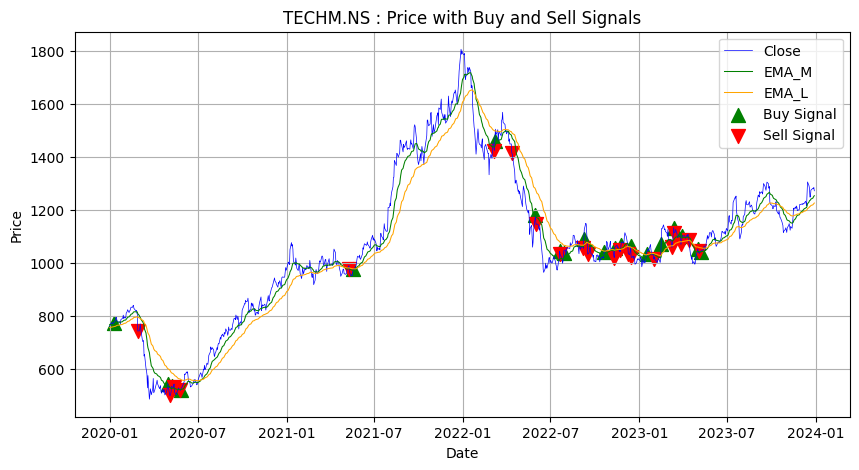

[*********************100%***********************]  1 of 1 completed



Order book for TITAN.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  84 Shares are bought at ₹1184.8499755859375 on 2020-01-15 00:00:00
SELL:  84 Shares are sold at ₹1176.199951171875 on 2020-01-21 00:00:00
BUY:  83 Shares are bought at ₹1187.75 on 2020-01-31 00:00:00
SELL:  83 Shares are sold at ₹1186.4000244140625 on 2020-02-03 00:00:00
BUY:  77 Shares are bought at ₹1277.9000244140625 on 2020-02-27 00:00:00
SELL:  77 Shares are sold at ₹1254.5 on 2020-02-28 00:00:00
BUY:  96 Shares are bought at ₹1013.8499755859375 on 2020-04-09 00:00:00
SELL:  96 Shares are sold at ₹966.8499755859375 on 2020-04-13 00:00:00
BUY:  94 Shares are bought at ₹985.25 on 2020-04-16 00:00:00
SELL:  94 Shares are sold at ₹975.5 on 2020-04-17 00:00:00
BUY:  94 Shares are bought at ₹970.0499877929688 on 2020-04-30 00:00:00
SELL:  94 Shares are sold at ₹891.8499755859375 on 2020-05-04 00:00:00
BUY:  94 Shares are bought at ₹892.75 on 2020-05-26 00:00:00
SELL:  94 Sha

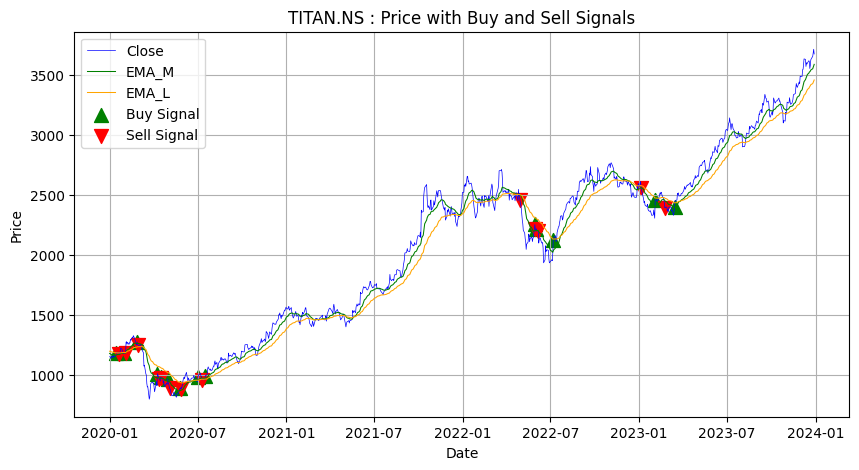

[*********************100%***********************]  1 of 1 completed



Order book for TRENT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  200 Shares are bought at ₹498.8999938964844 on 2020-04-23 00:00:00
SELL:  200 Shares are sold at ₹485.75 on 2020-04-24 00:00:00
BUY:  197 Shares are bought at ₹494.0 on 2020-04-27 00:00:00
SELL:  197 Shares are sold at ₹491.75 on 2020-04-28 00:00:00
BUY:  191 Shares are bought at ₹505.0 on 2020-04-30 00:00:00
SELL:  191 Shares are sold at ₹477.54998779296875 on 2020-05-04 00:00:00
BUY:  199 Shares are bought at ₹459.54998779296875 on 2020-05-26 00:00:00
258 96
SELL:  199 Shares are sold at ₹684.5999755859375 on 2021-01-12 00:00:00
BUY:  201 Shares are bought at ₹677.75 on 2021-01-19 00:00:00
SELL:  201 Shares are sold at ₹679.9500122070312 on 2021-01-20 00:00:00
BUY:  205 Shares are bought at ₹665.75 on 2021-02-02 00:00:00
495 272
SELL:  205 Shares are sold at ₹1034.800048828125 on 2021-12-28 00:00:00
BUY:  199 Shares are bought at ₹1065.0 on 2021-12-31 00:00:00
SELL:  199 

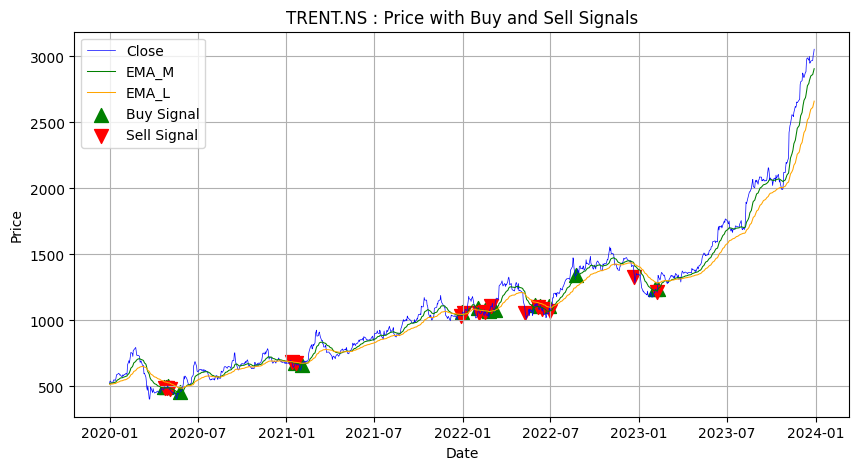

[*********************100%***********************]  1 of 1 completed



Order book for ULTRACEMCO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  22 Shares are bought at ₹4474.25 on 2020-02-04 00:00:00
SELL:  22 Shares are sold at ₹4475.7001953125 on 2020-02-18 00:00:00
BUY:  28 Shares are bought at ₹3466.10009765625 on 2020-04-13 00:00:00
SELL:  28 Shares are sold at ₹3403.25 on 2020-04-21 00:00:00
BUY:  28 Shares are bought at ₹3434.35009765625 on 2020-04-29 00:00:00
SELL:  28 Shares are sold at ₹3347.60009765625 on 2020-05-04 00:00:00
BUY:  27 Shares are bought at ₹3546.699951171875 on 2020-05-13 00:00:00
SELL:  27 Shares are sold at ₹3307.800048828125 on 2020-05-18 00:00:00
BUY:  26 Shares are bought at ₹3438.14990234375 on 2020-05-19 00:00:00
502 92
SELL:  26 Shares are sold at ₹7458.5498046875 on 2022-01-06 00:00:00
BUY:  25 Shares are bought at ₹7557.9501953125 on 2022-01-07 00:00:00
SELL:  25 Shares are sold at ₹7434.39990234375 on 2022-01-19 00:00:00
BUY:  25 Shares are bought at ₹7516.25 on 2022-02-01 

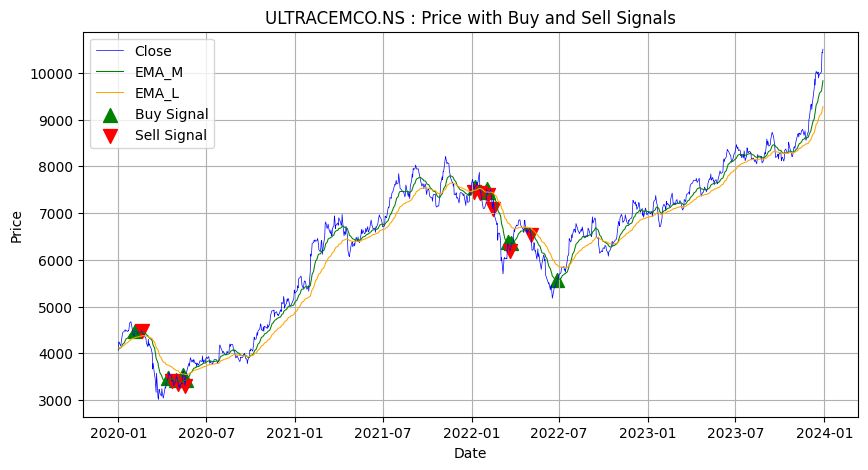

[*********************100%***********************]  1 of 1 completed



Order book for WIPRO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  398 Shares are bought at ₹251.10000610351562 on 2020-01-17 00:00:00
SELL:  398 Shares are sold at ₹247.10000610351562 on 2020-01-21 00:00:00
BUY:  402 Shares are bought at ₹244.4499969482422 on 2020-02-12 00:00:00
SELL:  402 Shares are sold at ₹239.89999389648438 on 2020-02-26 00:00:00
BUY:  490 Shares are bought at ₹196.6999969482422 on 2020-03-31 00:00:00
SELL:  490 Shares are sold at ₹189.5 on 2020-04-01 00:00:00
BUY:  484 Shares are bought at ₹191.89999389648438 on 2020-04-07 00:00:00
SELL:  484 Shares are sold at ₹189.1999969482422 on 2020-04-13 00:00:00
BUY:  480 Shares are bought at ₹190.9499969482422 on 2020-04-30 00:00:00
SELL:  480 Shares are sold at ₹190.0500030517578 on 2020-05-04 00:00:00
BUY:  488 Shares are bought at ₹187.0500030517578 on 2020-05-06 00:00:00
SELL:  488 Shares are sold at ₹184.10000610351562 on 2020-05-07 00:00:00
BUY:  480 Shares are bought a

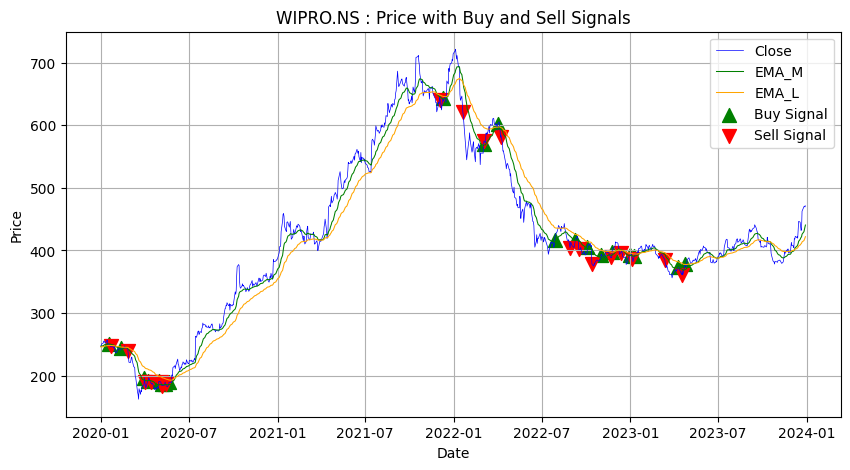

In [8]:
""" Main Execution block
"""

""" Followig parameters can be modified as per requirement:
    1. Wiki source for ticker list
    2. Period of historical price extract
    3. Initial investment amount
    4. Stop loss percentage
    5. Start and End dates
"""

# url for NIFTY50 stocks
url = 'https://en.wikipedia.org/wiki/NIFTY_50'
period = '5y'
investment = 100000
stop_loss_pct = 0.02
duration = 25
start = '2020-01-01'
end = '2023-12-31'

tickers = get_ticker_list(url)
#ticker = "WIPRO.NS"
return_data = []

for ticker in tickers:
    hist_price = extract_hist_price(ticker, period)
    if len(hist_price) is not 0:
       hist_price = add_ema_indicators(hist_price, 5, 20, 50)
       data = hist_price.loc[(hist_price.index >= start) & (hist_price.index <= end)]
       calculate_return(data, ticker, start, end, investment, stop_loss_pct, duration)

In [9]:
header = ['Ticker', 'Earning - Strategy', 'ROI - Strategy', 'Earning - Buy/ Hold', 'ROI - Buy/ Hold']
df_return = pd.DataFrame(return_data, columns=header)
#df_return

In [10]:
round(sum(df_return['Earning - Strategy']), 2)

9497954.81

In [11]:
round(sum(df_return['Earning - Strategy']) * 100/(investment * len(df_return)), 2)

189.96

In [12]:
round(sum(df_return['Earning - Buy/ Hold']), 2)

7534387.44

In [13]:
round(sum(df_return['Earning - Buy/ Hold']) * 100/(investment * len(df_return)), 2)

150.69

In [14]:
len(df_return)

50